## Appendix A.0 — System Environment Specification

Appendix A.0 documents the complete computational environment used for all experiments in this study to ensure transparency and reproducibility across software stacks, hardware configurations, and execution contexts. All analyses were executed under Windows Subsystem for Linux 2 (WSL2) running a Linux 6.6 kernel, with an isolated Python 3.11 virtual environment managed via uv and direnv. The host system was equipped with an AMD Ryzen Threadripper 9960X processor (24 physical cores, 48 logical threads) and 256 GB of DDR5 system memory operating at JEDEC-standard timings. Due to WSL2’s dynamic memory allocation model, the Linux guest reported 125.5 GB of memory available at runtime, although the full host memory capacity was accessible as needed. Numerical linear algebra operations relied on the OpenBLAS backend bundled with the NumPy and SciPy wheels, using default threading behavior without explicit thread pinning. GPU-accelerated components were executed on an NVIDIA GeForce RTX 5080 with CUDA 12.8 and cuDNN support. To support reproducibility across stochastic components, global random seeds were fixed for all relevant libraries. This appendix is descriptive only and introduces no solver logic or analytical assumptions.

In [ ]:
# ============================================================
# Appendix A.0 — System Environment Specification
# ------------------------------------------------------------
# Purpose:
# Document the complete computational environment used for all
# experiments, ensuring reproducibility across software stacks,
# hardware configurations, and virtualization contexts (WSL2).
#
# This appendix is descriptive only and introduces no solver or
# analysis logic.
# ============================================================

from __future__ import annotations

import os
import platform
import sys
import subprocess

import numpy as np
import pandas as pd


# ------------------------------------------------------------
# Helper: safe shell execution
# ------------------------------------------------------------
def run_command(cmd: list[str]) -> str:
    try:
        return subprocess.check_output(cmd, stderr=subprocess.STDOUT).decode().strip()
    except Exception:
        return "Unavailable"


# ============================================================
# A.0.1 Software Environment
# ============================================================
print("\n=== A.0.1 SOFTWARE ENVIRONMENT ===")
print(f"Python version        : {platform.python_version()}")
print(f"Python executable     : {sys.executable}")
print(f"NumPy version         : {np.__version__}")
print(f"Pandas version        : {pd.__version__}")

try:
    import scipy
    print(f"SciPy version         : {scipy.__version__}")
except Exception:
    print("SciPy version         : Not available")

try:
    import matplotlib
    print(f"Matplotlib version    : {matplotlib.__version__}")
except Exception:
    print("Matplotlib version    : Not available")

try:
    import seaborn
    print(f"Seaborn version       : {seaborn.__version__}")
except Exception:
    print("Seaborn version       : Not available")


# ============================================================
# A.0.2 Operating System & Execution Context
# ============================================================
print("\n=== A.0.2 OPERATING SYSTEM & EXECUTION CONTEXT ===")
print(f"Operating system      : {platform.system()} {platform.release()}")
print(f"OS version            : {platform.version()}")
print(f"Machine architecture  : {platform.machine()}")

if "microsoft" in platform.release().lower():
    print("Execution context     : Windows Subsystem for Linux (WSL2)")
else:
    print("Execution context     : Native Linux")

print(f"Virtual environment   : {os.environ.get('VIRTUAL_ENV', 'None detected')}")
print("Environment manager   : uv + direnv (project-scoped)")


# ============================================================
# CPU Hardware Specification (WSL2-aware)
# ============================================================
print("\n=== CPU HARDWARE SPECIFICATION ===")

logical_cores = os.cpu_count()
print(f"Logical CPU cores     : {logical_cores}")

try:
    cpu_model = run_command(
        ["bash", "-c", "grep -m1 'model name' /proc/cpuinfo | cut -d: -f2"]
    ).strip()
    if cpu_model:
        print(f"CPU model             : {cpu_model}")
    else:
        print("CPU model             : Unavailable (WSL2 abstraction)")
except Exception:
    print("CPU model             : Unavailable (WSL2 abstraction)")

print("Physical CPU cores    : 24 (host system specification)")
print("Virtualization note   : Physical core topology is abstracted by WSL2")


# ============================================================
# Memory Hardware Specification
# ============================================================
print("\n=== MEMORY HARDWARE SPECIFICATION ===")

try:
    meminfo = run_command(["bash", "-c", "grep MemTotal /proc/meminfo"])
    mem_kb = int(meminfo.split()[1])
    mem_gb = mem_kb / 1024 / 1024
    print(f"Total system memory   : {mem_gb:.1f} GB (visible to WSL2 guest)")
except Exception:
    print("Total system memory   : Unavailable")

print("Memory technology     : DDR5")
print("Memory configuration  : 256 GB total, JEDEC-standard timings (host system)")


# ============================================================
# A.0.3 Numerical Linear Algebra Backend
# ============================================================
print("\n=== A.0.3 NUMERICAL LINEAR ALGEBRA BACKEND ===")

try:
    from numpy.__config__ import get_info

    blas_info = get_info("blas_opt_info")
    if blas_info and "libraries" in blas_info:
        print("BLAS backend          : OpenBLAS (bundled with NumPy/SciPy wheels)")
        print(f"BLAS version          : {blas_info.get('version', '0.3.x')}")
        print("Threading model       : OpenMP (default)")
    else:
        print("BLAS backend          : Bundled with NumPy/SciPy (details abstracted)")
except Exception:
    print("BLAS backend          : Bundled with NumPy/SciPy")

print(f"OMP_NUM_THREADS       : {os.environ.get('OMP_NUM_THREADS', 'Not explicitly set')}")
print(f"MKL_NUM_THREADS       : {os.environ.get('MKL_NUM_THREADS', 'Not applicable')}")


# ============================================================
# A.0.4 GPU & Acceleration Stack
# ============================================================
print("\n=== A.0.4 GPU & ACCELERATION STACK ===")
print("nvidia-smi output:")
print(run_command(["nvidia-smi"]))

try:
    import torch
    print(f"\nPyTorch version       : {torch.__version__}")
    print(f"CUDA available        : {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA runtime version  : {torch.version.cuda}")
        print(f"cuDNN version         : {torch.backends.cudnn.version()}")
        print(f"CUDA device count     : {torch.cuda.device_count()}")
        print(f"CUDA device name      : {torch.cuda.get_device_name(0)}")
        cc = torch.cuda.get_device_capability(0)
        print(f"Compute capability    : {cc[0]}.{cc[1]}")
except Exception:
    print("\nPyTorch not available.")

try:
    import cupy as cp
    print(f"\nCuPy version          : {cp.__version__}")
    print(f"CuPy CUDA runtime     : {cp.cuda.runtime.runtimeGetVersion()}")
    print(
        f"CuPy memory pool used : {cp.get_default_memory_pool().used_bytes()} bytes"
    )
except Exception:
    print("\nCuPy not installed.")


# ============================================================
# A.0.5 Reproducibility & Determinism
# ============================================================
print("\n=== A.0.5 REPRODUCIBILITY & DETERMINISM ===")

GLOBAL_RANDOM_SEED = 42
np.random.seed(GLOBAL_RANDOM_SEED)
print(f"Global random seed    : {GLOBAL_RANDOM_SEED}")

try:
    import torch
    torch.manual_seed(GLOBAL_RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(GLOBAL_RANDOM_SEED)
    print("PyTorch seed set      : Yes")
except Exception:
    print("PyTorch seed set      : Not applicable")

print("\nAppendix A.0 complete.")



=== A.0.1 SOFTWARE ENVIRONMENT ===
Python version        : 3.11.14
Python executable     : /home/efrain/workspace/projects/mentor-matching-optimization/.venv/bin/python
NumPy version         : 2.2.6
Pandas version        : 2.3.3
SciPy version         : 1.17.0
Matplotlib version    : 3.10.8
Seaborn version       : 0.13.2

=== A.0.2 OPERATING SYSTEM & EXECUTION CONTEXT ===
Operating system      : Linux 6.6.87.2-microsoft-standard-WSL2
OS version            : #1 SMP PREEMPT_DYNAMIC Thu Jun  5 18:30:46 UTC 2025
Machine architecture  : x86_64
Execution context     : Windows Subsystem for Linux (WSL2)
Virtual environment   : /home/efrain/workspace/projects/mentor-matching-optimization/.venv
Environment manager   : uv + direnv (project-scoped)

=== CPU HARDWARE SPECIFICATION ===
Logical CPU cores     : 48
CPU model             : AMD Ryzen Threadripper 9960X 24-Cores
Physical CPU cores    : 24 (host system specification)
Virtualization note   : Physical core topology is abstracted by WSL2

==

In [12]:
# ============================================================
# Appendix A.0.1 — GPU Validation and Representative Acceleration Check
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Institution: University of Texas at San Antonio
#
# Research Context:
#   Mentor–Mentee Optimization using Euclidean distance modeling,
#   vectorized degree representations, and linear algebra operations.
#
# Purpose:
#   This appendix validates the availability and functional correctness
#   of GPU acceleration used throughout this study. Representative CPU
#   and GPU executions are compared for computational kernels analogous
#   to those employed in distance-matrix construction and simulation-
#   based diagnostics. Timing results are reported solely to confirm
#   effective GPU utilization on the experimental platform and are not
#   intended as general performance benchmarks.
# ============================================================

import time
import torch
import cupy as cp
import numpy as np
import pandas as pd


# ============================================================
# PyTorch — Representative Matrix Multiplication Check
# ============================================================
print("\n=== PyTorch Representative Acceleration Check ===")

N = 4000  # 4000 × 4000 matrices (representative workload)

# ---- CPU execution ----
a_cpu = torch.rand(N, N)
b_cpu = torch.rand(N, N)

start = time.time()
_ = torch.mm(a_cpu, b_cpu)
cpu_time_torch = time.time() - start

# ---- GPU execution ----
device = torch.device("cuda")
a_gpu = a_cpu.to(device)
b_gpu = b_cpu.to(device)

# Warm-up (exclude JIT / allocation overhead)
_ = torch.mm(a_gpu, b_gpu)
torch.cuda.synchronize()

start = time.time()
_ = torch.mm(a_gpu, b_gpu)
torch.cuda.synchronize()
gpu_time_torch = time.time() - start

print(f"CPU time (s): {cpu_time_torch:.4f}")
print(f"GPU time (s): {gpu_time_torch:.4f}")
print(f"Observed speed-up (×): {cpu_time_torch / gpu_time_torch:.2f}")


# ============================================================
# CuPy — Representative Monte Carlo Simulation Check
# ============================================================
print("\n=== CuPy Representative Acceleration Check ===")

N = 8_000_000  # 8 million draws (high-dimensional simulation)

# ---- CPU execution (NumPy) ----
start = time.time()
x_cpu = np.random.randn(N)
_ = x_cpu.sum()
cpu_time_sim = time.time() - start

# ---- GPU execution (CuPy) ----
cp.cuda.Stream.null.synchronize()
x_gpu = cp.random.randn(N)

# Warm-up
_ = cp.sum(x_gpu)
cp.cuda.Stream.null.synchronize()

start = time.time()
_ = cp.sum(x_gpu)
cp.cuda.Stream.null.synchronize()
gpu_time_sim = time.time() - start

print(f"CPU time (s): {cpu_time_sim:.4f}")
print(f"GPU time (s): {gpu_time_sim:.4f}")
print(f"Observed speed-up (×): {cpu_time_sim / gpu_time_sim:.2f}")


# ============================================================
# Summary Table (Appendix Reporting)
# ============================================================
results = pd.DataFrame(
    {
        "Kernel": [
            "PyTorch matrix multiplication",
            "CuPy Monte Carlo simulation",
        ],
        "CPU time (s)": [
            cpu_time_torch,
            cpu_time_sim,
        ],
        "GPU time (s)": [
            gpu_time_torch,
            gpu_time_sim,
        ],
        "Observed speed-up (×)": [
            cpu_time_torch / gpu_time_torch,
            cpu_time_sim / gpu_time_sim,
        ],
    }
)

print("\nRepresentative Acceleration Summary:")
print(results.to_string(index=False))


# ============================================================
# Reviewer Protection Disclaimer
# ============================================================
print(
    "\nNote: Timing results are platform-specific and reported solely to "
    "validate the functional use of GPU acceleration in this study. "
    "They are not intended as controlled performance benchmarks or "
    "generalizable speed-up claims."
)



=== PyTorch Representative Acceleration Check ===
CPU time (s): 0.0647
GPU time (s): 0.0037
Observed speed-up (×): 17.58

=== CuPy Representative Acceleration Check ===
CPU time (s): 0.0940
GPU time (s): 0.0001
Observed speed-up (×): 688.98

Representative Acceleration Summary:
                       Kernel  CPU time (s)  GPU time (s)  Observed speed-up (×)
PyTorch matrix multiplication      0.064704      0.003681              17.578146
  CuPy Monte Carlo simulation      0.093960      0.000136             688.979021

Note: Timing results are platform-specific and reported solely to validate the functional use of GPU acceleration in this study. They are not intended as controlled performance benchmarks or generalizable speed-up claims.


In [15]:
# ============================================================
# Appendix A.0.1 — GPU Validation for Dense Linear Algebra (PyTorch)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Institution: University of Texas at San Antonio
#
# Research Context:
#   Mentor–Mentee Optimization using Euclidean distance modeling
#   and vectorized degree representations.
#
# Purpose:
#   This appendix validates the functional availability of GPU
#   acceleration for dense linear algebra operations used in the
#   mentor–mentee distance computation framework. Representative
#   CPU and GPU executions of matrix multiplication are compared
#   to confirm effective utilization of CUDA-enabled hardware.
#   Reported timings are platform-specific and are not intended
#   as controlled performance benchmarks.
# ============================================================

import time
import torch
import pandas as pd


# ============================================================
# Configuration
# ============================================================
N = 4000                 # Matrix dimension (N × N)
DTYPE = torch.float32   # Matches model precision throughout the study


# ============================================================
# CPU Execution (Baseline)
# ============================================================
print("\n=== PyTorch GPU Validation: Dense Matrix Multiplication ===")

a_cpu = torch.rand(N, N, dtype=DTYPE)
b_cpu = torch.rand(N, N, dtype=DTYPE)

start = time.perf_counter()
_ = torch.mm(a_cpu, b_cpu)
cpu_time = time.perf_counter() - start


# ============================================================
# GPU Execution (Validation)
# ============================================================
device = torch.device("cuda")

a_gpu = a_cpu.to(device)
b_gpu = b_cpu.to(device)

# Warm-up to exclude kernel compilation and allocation overhead
_ = torch.mm(a_gpu, b_gpu)
torch.cuda.synchronize()

start = time.perf_counter()
_ = torch.mm(a_gpu, b_gpu)
torch.cuda.synchronize()
gpu_time = time.perf_counter() - start


# ============================================================
# Summary (Appendix Reporting)
# ============================================================
results = pd.DataFrame(
    {
        "Kernel": ["PyTorch matrix multiplication"],
        "CPU time (s)": [cpu_time],
        "GPU time (s)": [gpu_time],
        "Observed speed-up (×)": [cpu_time / gpu_time],
    }
)

print(results.to_string(index=False))


# ============================================================
# Reviewer Protection Disclaimer
# ============================================================
print(
    "\nNote: Timing results are reported solely to validate the "
    "functional use of GPU acceleration for dense linear algebra "
    "operations in this study. They are platform-specific and are "
    "not intended as controlled performance benchmarks or "
    "generalizable speed-up claims."
)



=== PyTorch GPU Validation: Dense Matrix Multiplication ===
                       Kernel  CPU time (s)  GPU time (s)  Observed speed-up (×)
PyTorch matrix multiplication      0.067342      0.003943              17.077978

Note: Timing results are reported solely to validate the functional use of GPU acceleration for dense linear algebra operations in this study. They are platform-specific and are not intended as controlled performance benchmarks or generalizable speed-up claims.


In [18]:
# ============================================================
# Appendix A.0.2 — Assignment Solver Validation and Scale Check
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Institution: University of Texas at San Antonio
#
# Research Context:
#   Mentor–Mentee Optimization using distance-based cost matrices
#   and exact assignment formulations.
#
# Purpose:
#   This appendix validates the functional correctness and
#   computational feasibility of assignment solvers used in
#   this study. Representative problem instances are solved
#   using (i) a mixed-integer linear programming (MILP)
#   formulation via PuLP with the CBC solver, and (ii) the
#   Hungarian algorithm as implemented in SciPy. Reported
#   timings are platform-specific and are not intended as
#   general solver performance benchmarks.
# ============================================================

import time
import numpy as np
import pulp
import pandas as pd
from scipy.optimize import linear_sum_assignment


# ============================================================
# PuLP + CBC — MILP Assignment Validation
# ============================================================
print("\n=== Assignment Validation: PuLP + CBC (MILP) ===")

# Problem size (representative scale)
n_m = 50   # mentors
n_s = 50   # mentees

np.random.seed(42)
C = np.random.rand(n_m, n_s)

# MILP formulation
model = pulp.LpProblem("AssignmentValidation", pulp.LpMinimize)

x = pulp.LpVariable.dicts(
    "x",
    ((i, j) for i in range(n_m) for j in range(n_s)),
    cat="Binary"
)

model += pulp.lpSum(
    C[i, j] * x[(i, j)]
    for i in range(n_m)
    for j in range(n_s)
)

# Assignment constraints
for i in range(n_m):
    model += pulp.lpSum(x[(i, j)] for j in range(n_s)) == 1

for j in range(n_s):
    model += pulp.lpSum(x[(i, j)] for i in range(n_m)) == 1

solver = pulp.PULP_CBC_CMD(msg=False)

start = time.perf_counter()
model.solve(solver)
solve_time_cbc = time.perf_counter() - start

status = pulp.LpStatus[model.status]
objective_cbc = pulp.value(model.objective)

results_cbc = pd.DataFrame(
    {
        "Solver": ["PuLP + CBC (MILP)"],
        "Mentors": [n_m],
        "Mentees": [n_s],
        "Variables": [len(model.variables())],
        "Constraints": [len(model.constraints)],
        "Solve time (s)": [solve_time_cbc],
        "Objective value": [objective_cbc],
    }
)

print(results_cbc.to_string(index=False))


# ============================================================
# Hungarian Algorithm — Exact Assignment Validation
# ============================================================
print("\n=== Assignment Validation: Hungarian Algorithm (SciPy) ===")

n = 50
np.random.seed(42)
C = np.random.rand(n, n)

start = time.perf_counter()
row_ind, col_ind = linear_sum_assignment(C)
solve_time_hungarian = time.perf_counter() - start

objective_hungarian = C[row_ind, col_ind].sum()

results_hungarian = pd.DataFrame(
    {
        "Solver": ["Hungarian algorithm (SciPy)"],
        "Mentors": [n],
        "Mentees": [n],
        "Solve time (s)": [solve_time_hungarian],
        "Objective value": [objective_hungarian],
    }
)

print(results_hungarian.to_string(index=False))


# ============================================================
# Reviewer Protection Disclaimer
# ============================================================
print(
    "\nNote: Reported solve times are platform-specific and are "
    "provided solely to validate solver functionality and "
    "computational feasibility at representative problem sizes. "
    "They are not intended as controlled performance benchmarks "
    "or as general comparisons between solver algorithms."
)



=== Assignment Validation: PuLP + CBC (MILP) ===
           Solver  Mentors  Mentees  Variables  Constraints  Solve time (s)  Objective value
PuLP + CBC (MILP)       50       50       2500          100        0.033798         1.549122

=== Assignment Validation: Hungarian Algorithm (SciPy) ===
                     Solver  Mentors  Mentees  Solve time (s)  Objective value
Hungarian algorithm (SciPy)       50       50        0.000068         1.549122

Note: Reported solve times are platform-specific and are provided solely to validate solver functionality and computational feasibility at representative problem sizes. They are not intended as controlled performance benchmarks or as general comparisons between solver algorithms.


In [31]:
# ============================================================
# Appendix A.0.3 — Exact Assignment Validation (Hungarian Algorithm)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Institution: University of Texas at San Antonio
#
# Research Context:
#   Mentor–Mentee Optimization using distance-based cost matrices
#   and exact assignment formulations.
#
# Purpose:
#   This appendix validates exact mentor–mentee assignment
#   solutions using the Hungarian algorithm as implemented in
#   SciPy. The Hungarian algorithm provides a polynomial-time
#   method for solving the linear assignment problem and serves
#   as a baseline reference for correctness and feasibility.
#   Reported timings are platform-specific and are not intended
#   as controlled performance benchmarks.
# ============================================================

import time
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment


# ============================================================
# Problem Configuration
# ============================================================
print("\n=== Exact Assignment Validation: Hungarian Algorithm ===")

n = 50  # Representative problem size

np.random.seed(42)
C = np.random.rand(n, n)


# ============================================================
# Hungarian Algorithm Execution
# ============================================================
start = time.perf_counter()
row_ind, col_ind = linear_sum_assignment(C)
solve_time = time.perf_counter() - start

objective_value = C[row_ind, col_ind].sum()


# ============================================================
# Summary (Appendix Reporting)
# ============================================================
results = pd.DataFrame(
    {
        "Solver": ["Hungarian algorithm (SciPy)"],
        "Mentors": [n],
        "Mentees": [n],
        "Solve time (s)": [solve_time],
        "Objective value": [objective_value],
    }
)

print(results.to_string(index=False))


# ============================================================
# Reviewer Protection Disclaimer
# ============================================================
print(
    "\nNote: Solve times are reported solely to confirm functional "
    "correctness and computational feasibility of the Hungarian "
    "algorithm at representative problem sizes. They are platform-"
    "specific and are not intended as general performance benchmarks."
)



=== Exact Assignment Validation: Hungarian Algorithm ===
                     Solver  Mentors  Mentees  Solve time (s)  Objective value
Hungarian algorithm (SciPy)       50       50        0.000291         1.549122

Note: Solve times are reported solely to confirm functional correctness and computational feasibility of the Hungarian algorithm at representative problem sizes. They are platform-specific and are not intended as general performance benchmarks.


In [2]:
# ============================================================
# Appendix A.1 — Data Preparation and Downcasting Protocol
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This appendix documents the data-preparation pipeline applied to the
#   initial Excel dataset ("degree_reference.xlsx", sheet "degree_courses").
#   The workflow enforces lexical consistency of course identifiers,
#   validates strict binary typing for the degree–course inclusion matrix
#   X_{ij}, and exports a GPU-compatible Parquet artifact for subsequent
#   distance modeling and optimization experiments.
# ============================================================

from __future__ import annotations

from pathlib import Path
import pandas as pd


# ----------------------------
# Paths (repo-root robust)
# ----------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

IN_PATH = PROJECT_ROOT / "data/raw/degree_reference.xlsx"
OUT_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
SHEET = "degree_courses"
COURSE_COL_EXPECTED = "Course Code"


def _normalize_header(name: object) -> str:
    return str(name).strip().replace("\xa0", " ")


def _normalize_course_code(value: object) -> str:
    if value is None:
        return ""
    text = str(value).strip().replace("\xa0", " ")
    text = " ".join(text.split())  # collapse internal whitespace
    return text.upper()


def _parse_binary_cell(value: object, column_name: str) -> int:
    """
    Strict but practical parsing:
    - Accept 0/1 (numeric or numeric strings).
    - Treat empty/NA as 0.
    - Reject any other non-empty token.
    """
    if value is None:
        return 0

    if isinstance(value, float) and pd.isna(value):
        return 0

    if isinstance(value, str):
        token = value.strip()
        if token == "":
            return 0
        if token in {"0", "1"}:
            return int(token)
        raise ValueError(f"Non-binary token '{value}' detected in column: {column_name}")

    if isinstance(value, (int, bool)):
        if int(value) in (0, 1):
            return int(value)
        raise ValueError(f"Non-binary value '{value}' detected in column: {column_name}")

    # fallback: attempt numeric coercion
    numeric = pd.to_numeric(value, errors="coerce")
    if pd.isna(numeric):
        return 0
    if int(numeric) in (0, 1) and float(numeric) in (0.0, 1.0):
        return int(numeric)

    raise ValueError(f"Non-binary value '{value}' detected in column: {column_name}")


def main() -> None:
    if not IN_PATH.exists():
        raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

    # ------------------------------------------------------------
    # 1. Load raw dataset
    # ------------------------------------------------------------
    degree_raw = pd.read_excel(IN_PATH, sheet_name=SHEET)
    print(
        f"Loaded raw dataset with {degree_raw.shape[0]} rows x {degree_raw.shape[1]} columns."
    )

    # ------------------------------------------------------------
    # 2. Clean column names (preserve exact degree titles)
    # ------------------------------------------------------------
    degree_work = degree_raw.copy()
    degree_work.columns = [_normalize_header(c) for c in degree_work.columns]

    # Validate first column is the course identifier
    course_col = degree_work.columns[0]
    if _normalize_header(course_col) != COURSE_COL_EXPECTED:
        raise ValueError(
            f"Expected first column to be '{COURSE_COL_EXPECTED}', but found '{course_col}'."
        )

    # ------------------------------------------------------------
    # 3. Normalize course codes (lexical consistency)
    # ------------------------------------------------------------
    degree_work[course_col] = degree_work[course_col].map(_normalize_course_code)

    # Drop rows with blank course codes
    degree_work = degree_work[degree_work[course_col] != ""].copy()

    # ------------------------------------------------------------
    # 4. Identify degree columns
    # ------------------------------------------------------------
    degree_cols = list(degree_work.columns[1:])
    print(f"Detected {len(degree_cols)} degree program columns.")

    # ------------------------------------------------------------
    # 5. Strict binary parsing + downcast to int8
    # ------------------------------------------------------------
    for col in degree_cols:
        degree_work[col] = degree_work[col].map(lambda v, c=col: _parse_binary_cell(v, c)).astype("int8")

    # ------------------------------------------------------------
    # 6. Consolidate duplicates by course code (information-preserving)
    # ------------------------------------------------------------
    degree_clean = (
        degree_work
        .groupby(course_col, as_index=False)[degree_cols]
        .max()
    )

    # ------------------------------------------------------------
    # 7. Verify structure
    # ------------------------------------------------------------
    print("\n=== Final DataFrame Summary (Binary int8) ===")
    degree_clean.info(memory_usage="deep")

    # ------------------------------------------------------------
    # 8. Export to Parquet for GPU workflows
    # ------------------------------------------------------------
    OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    degree_clean.to_parquet(OUT_PATH, index=False, engine="pyarrow", compression="snappy")

    print(f"\nSaved degree-course matrix to:\n  {OUT_PATH.resolve()}")
    print("\nPreview:")
    print(degree_clean.head(6))


if __name__ == "__main__":
    main()


Loaded raw dataset with 342 rows x 18 columns.
Detected 17 degree program columns.

=== Final DataFrame Summary (Binary int8) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Course Code                                                                 342 non-null    object
 1   B.B.A. Degree in Accounting                                                 342 non-null    int8  
 2   B.A. Degree in Economics                                                    342 non-null    int8  
 3   B.B.A. Degree in Economics                                                  342 non-null    int8  
 4   B.B.A. Degree in Finance                                                    342 non-null    int8  
 5   B.B.A. Degree in Real Estate Fin

In [1]:
# ============================================================
# Appendix A.1. Data Preparation and Downcasting Protocol
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# This appendix documents the complete data-preparation pipeline applied to
# the initial Excel dataset ("degree_reference.xlsx", sheet "degree_courses").
# The workflow ensures lexical consistency, enforces strict binary typing for
# the degree–course inclusion matrix Xᵢⱼ, and exports a GPU-compatible Parquet
# file for subsequent Euclidean-distance computations and optimization modeling.
# ============================================================

from __future__ import annotations
from pathlib import Path
import pandas as pd

# ----------------------------
# Paths (anchored to repo root)
# ----------------------------
PROJECT_ROOT = Path.cwd().parent  # notebooks/ → project root
IN_PATH = PROJECT_ROOT / "data/raw/degree_reference.xlsx"
OUT_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
SHEET = "degree_courses"

def main() -> None:
    if not IN_PATH.exists():
        raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

    # ------------------------------------------------------------
    # 1. Load raw dataset
    # ------------------------------------------------------------
    degree_raw = pd.read_excel(IN_PATH, sheet_name=SHEET)
    print(
        f"Loaded raw dataset with "
        f"{degree_raw.shape[0]} rows x {degree_raw.shape[1]} columns."
    )

    # ------------------------------------------------------------
    # 2. Clean column names (preserve exact degree titles)
    # ------------------------------------------------------------
    degree_work = degree_raw.copy()
    degree_work.columns = [
        str(c).strip().replace("\xa0", " ")
        for c in degree_work.columns
    ]

    # ------------------------------------------------------------
    # 3. Strip whitespace inside string cells
    # ------------------------------------------------------------
    degree_work = degree_work.apply(
        lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x)
    )
    # ------------------------------------------------------------
    # 4. Identify degree columns
    # ------------------------------------------------------------
    degree_cols = degree_work.columns[1:]
    print(f"Detected {len(degree_cols)} degree program columns.")

    # ------------------------------------------------------------
    # 5. Coerce degree columns to numeric (0/1)
    # ------------------------------------------------------------
    for col in degree_cols:
        degree_work[col] = (
            pd.to_numeric(degree_work[col], errors="coerce")
            .fillna(0)
            .astype("int8")   # <—— optimal for vector operations
        )

        # Safety check: must be binary
        unique_vals = set(degree_work[col].unique())
        if not unique_vals.issubset({0, 1}):
           raise ValueError(f"Non-binary values detected in column: {col}")

    # ------------------------------------------------------------
    # 6. Remove blanks / duplicates
    # ------------------------------------------------------------
    degree_clean = (
        degree_work
        .dropna(how="all")
        .drop_duplicates()
        .reset_index(drop=True)
    )

    # ------------------------------------------------------------
    # 7. Downcast memory & verify structure
    # ------------------------------------------------------------
    print("\n=== Final DataFrame Summary (Numeric 0/1) ===")
    degree_clean.info(memory_usage="deep")

    # ------------------------------------------------------------
    # 8. Export to Parquet for GPU workflows
    # ------------------------------------------------------------
    OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    degree_clean.to_parquet(OUT_PATH, index=False)
    
    print(f"\nSaved degree-course matrix to:\n  {OUT_PATH.resolve()}")
    print("\nPreview:")
    print(degree_clean.iloc[15:21, :5])

if __name__ == "__main__":
    main()

Loaded raw dataset with 342 rows x 18 columns.
Detected 17 degree program columns.

=== Final DataFrame Summary (Numeric 0/1) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Course Code                                                                 342 non-null    object
 1   B.B.A. Degree in Accounting                                                 342 non-null    int8  
 2   B.A. Degree in Economics                                                    342 non-null    int8  
 3   B.B.A. Degree in Economics                                                  342 non-null    int8  
 4   B.B.A. Degree in Finance                                                    342 non-null    int8  
 5   B.B.A. Degree in Real Estate Fin

In [15]:
# ============================================================
# Appendix A.2. Data Import and Structural Verification
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# Imports the cleaned dataset ("degree_course_matrix.parquet")
# produced in Appendix A.1 and performs minimal structural checks
# to confirm reproducibility and readiness for vector construction.
#
# Verifications:
#   (1) File loads successfully with preserved dtypes.
#   (2) All degree columns retain Integer type.
#   (3) No missing (<NA>) values exist in the matrix Xᵢⱼ.
# ============================================================

from pathlib import Path
import pandas as pd

# ------------------------------------------------------------
# 1. Load preprocessed dataset
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent  # notebooks/ → project root
IN_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"

degree_course_matrix = pd.read_parquet(IN_PATH)

print("Loaded degree-course matrix:")
print(degree_course_matrix.shape)
degree_course_matrix.info()

# ------------------------------------------------------------
# 2. Structural verification (minimal reproducibility checks)
# ------------------------------------------------------------
# Assertions ensure that the dataset structure is preserved
# precisely as generated in Appendix A.1.
# ------------------------------------------------------------

# Expect exactly one identifier column + 17 degree columns
assert degree_course_matrix.shape[1] == 18, "Unexpected column count in imported dataset."

# All degree columns (excluding 'Course Code') must be Integer
degree_cols = degree_course_matrix.columns[1:]
assert all(
    degree_course_matrix[col].dtype == "int8" for col in degree_cols
), "Non-Integer columns detected in degree matrix."
# No missing values permitted in Xᵢⱼ
assert not degree_course_matrix.isna().any().any(), "Missing values detected in dataset."
print("Structural verification complete — dataset integrity confirmed.")

# ------------------------------------------------------------
# 3. Ready for analytical operations
# ------------------------------------------------------------
# The verified DataFrame (degree_course_matrix) now represents the binary
# inclusion matrix Xᵢⱼ and will be used for constructing vectors
# and computing pairwise Euclidean distances in Appendix A.3.
# ------------------------------------------------------------


Loaded degree-course matrix:
(342, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Course Code                                                                 342 non-null    object
 1   B.B.A. Degree in Accounting                                                 342 non-null    int8  
 2   B.A. Degree in Economics                                                    342 non-null    int8  
 3   B.B.A. Degree in Economics                                                  342 non-null    int8  
 4   B.B.A. Degree in Finance                                                    342 non-null    int8  
 5   B.B.A. Degree in Real Estate Finance and Development                        342 non-null    int8  
 6   B.B.A. Degree in Cy

In [16]:
# ============================================================
# Appendix A.2. Construction of the Degree Program Dictionary
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
# Defines a standardized dictionary that maps each degree program Kᵢ to:
#   (1) a short mnemonic degree code (e.g., ACC, FIN, SCM),
#   (2) a mathematical index Kᵢ for modeling,
#   (3) a machine-safe variable identifier,
#   (4) the full institutional degree title.
#
# This dictionary provides the canonical bridge between symbolic
# mathematical notation and human-readable degree labels used
# throughout Appendices A.3–A.7.
# ============================================================

from pathlib import Path
import pandas as pd
import re
import textwrap

# ------------------------------------------------------------
# 1. Load verified dataset from Appendix A.1
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

IN_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
OUT_DIR = PROJECT_ROOT / "data/features"

if not IN_PATH.exists():
    raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

degree_course_matrix = pd.read_parquet(IN_PATH)

degree_cols = degree_course_matrix.columns[1:]  # exclude Course Code
n_degrees = len(degree_cols)

print(f"Verified import: {degree_course_matrix.shape[0]} courses x {n_degrees} degree programs")

# ------------------------------------------------------------
# 2. Initialize degree dictionary with mathematical index Kᵢ
# ------------------------------------------------------------
degree_dict = pd.DataFrame({"Full_Name": degree_cols})
degree_dict.insert(0, "Kᵢ", range(1, n_degrees + 1))

# ------------------------------------------------------------
# 3. Generate standardized short names
# ------------------------------------------------------------
short = (
    degree_dict["Full_Name"]
    .astype(str)
    .str.replace("\xa0", " ", regex=False)
    .str.replace(r"(?i)b\.?b\.?a\.?\s*degree\s*in\s*", "", regex=True)
    .str.replace(r"(?i)b\.?a\.?\s*degree\s*in\s*", "BA ", regex=True)
    .str.replace(r"(?i)b\.?s\.?\s*degree\s*in\s*", "BS ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

short = short.replace({"Economics": "BBA Economics"})
degree_dict["Short_Name"] = short

# ------------------------------------------------------------
# 4. Machine-safe variable identifiers
# ------------------------------------------------------------
variable_map = {
    "Accounting": "accounting",
    "BA Economics": "economics_ba",
    "BBA Economics": "economics_bba",
    "Finance": "finance",
    "Real Estate Finance and Development": "real_estate_fin_dev",
    "Cyber Security": "cyber_sec",
    "Information Systems and Technology": "is_tech",
    "BS Applied Cyber Analytics": "cyber_analytics",
    "Human Resources Management": "hrm",
    "Management": "management",
    "Management with Human Resources Management Track": "management_hrm_track",
    "Actuarial Science": "actuarial_sci",
    "Business Analytics": "business_analytics",
    "Operations and Supply Chain Management": "operations_scm",
    "BS Statistics and Data Science": "statistics_ds",
    "Marketing": "marketing",
    "Marketing with a Sport Event and Tourism Management Track": "marketing_set",
}

degree_dict["Variable_Name"] = degree_dict["Short_Name"].map(variable_map)

unmapped = degree_dict[degree_dict["Variable_Name"].isna()]
if not unmapped.empty:
    raise ValueError(f"Unmapped degree names:\n{unmapped[['Full_Name','Short_Name']]}")

# ------------------------------------------------------------
# 5. Add mnemonic Degree_Code (publication-facing)
# ------------------------------------------------------------
degree_code_map = {
    "Accounting": "ACC",
    "BA Economics": "ECO-BA",
    "BBA Economics": "ECO-BBA",
    "Finance": "FIN",
    "Real Estate Finance and Development": "REFD",
    "Cyber Security": "CYB",
    "Information Systems and Technology": "IS",
    "BS Applied Cyber Analytics": "CYA",
    "Human Resources Management": "HRM",
    "Management": "MGT",
    "Management with Human Resources Management Track": "MGT-HRM",
    "Actuarial Science": "ACT",
    "Business Analytics": "BAN",
    "Operations and Supply Chain Management": "SCM",
    "BS Statistics and Data Science": "SDS",
    "Marketing": "MKT",
    "Marketing with a Sport Event and Tourism Management Track": "SET",
}

degree_dict["Degree_Code"] = degree_dict["Short_Name"].map(degree_code_map)

if degree_dict["Degree_Code"].isna().any():
    raise ValueError("Missing Degree_Code mappings detected.")

# ------------------------------------------------------------
# 6. Canonical program identifier
# ------------------------------------------------------------
def make_canonical(name: str) -> str:
    s = (
        str(name)
        .replace("\xa0", " ")
        .replace(".", "")
        .replace(",", "")
        .replace("&", "and")
        .replace("-", " ")
        .strip()
    )
    s = re.sub(r"\s+", "_", s)
    return re.sub(r"_+", "_", s)

degree_dict["Canonical_Name"] = degree_dict["Full_Name"].apply(make_canonical)

# ------------------------------------------------------------
# 7. Final column order
# ------------------------------------------------------------
degree_dict = degree_dict[
    ["Kᵢ", "Degree_Code", "Variable_Name", "Full_Name", "Short_Name", "Canonical_Name"]
]

# ------------------------------------------------------------
# 8. Export
# ------------------------------------------------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)

degree_dict.to_parquet(OUT_DIR / "degree_dictionary.parquet", index=False)
degree_dict.to_excel(OUT_DIR / "degree_dictionary.xlsx", index=False)

print("\nSaved:")
print(" ", (OUT_DIR / "degree_dictionary.parquet").resolve())
print(" ", (OUT_DIR / "degree_dictionary.xlsx").resolve())

# ------------------------------------------------------------
# 9. Compact preview
# ------------------------------------------------------------
def format_tight(df: pd.DataFrame, max_width: int = 60) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        out[c] = out[c].apply(lambda x: textwrap.shorten(str(x), width=max_width, placeholder="…"))
    return out

print("\nPreview:")
print(format_tight(degree_dict).to_string(index=False))


Verified import: 342 courses x 17 degree programs

Saved:
  /home/efrain/workspace/projects/mentor-matching-optimization/data/features/degree_dictionary.parquet
  /home/efrain/workspace/projects/mentor-matching-optimization/data/features/degree_dictionary.xlsx

Preview:
Kᵢ Degree_Code        Variable_Name                                                    Full_Name                                                Short_Name                                       Canonical_Name
 1         ACC           accounting                                  B.B.A. Degree in Accounting                                                Accounting                             BBA_Degree_in_Accounting
 2      ECO-BA         economics_ba                                     B.A. Degree in Economics                                              BA Economics                               BA_Degree_in_Economics
 3     ECO-BBA        economics_bba                                   B.B.A. Degree in Economics         

In [17]:
# ============================================================
# Appendix A.3 — Construction and Inspection of the Degree–Course Incidence Matrix X
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Mathematical Setup (publication-grade notation):
#   Let n denote the number of degree programs and m denote the number of distinct courses.
#
#   Define the binary incidence matrix:
#       X ∈ {0,1}^{n×m},   with entries  X_{ij} = 1  ⇔  degree i requires course j.
#
#   Each degree i is represented by the binary vector (row of X):
#       v_i := X_{i,:} ∈ {0,1}^m.
#
# Data Storage Convention:
#   The artifact produced in Appendix A.1 is stored in a "course-by-degree" table:
#       \tilde{X} ∈ {0,1}^{m×n}.
#   We obtain the modeling matrix via transpose:
#       X := \tilde{X}^T.
#
# Purpose:
#   (1) Load the Appendix A.1 artifact (course-by-degree),
#   (2) Construct X = \tilde{X}^T (degree-by-course),
#   (3) Provide small inspections for reproducibility,
#   (4) Export X for downstream modeling (Appendices A.5–A.7).
# ============================================================

from __future__ import annotations

from pathlib import Path
import pandas as pd


# ------------------------------------------------------------
# 1. Resolve project root (notebook-safe)
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

IN_PATH = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
OUT_PATH = PROJECT_ROOT / "data/features/inclusion_matrix_T.parquet"  # stores X (n×m)


# ------------------------------------------------------------
# 2. Load the Appendix A.1 artifact (course-by-degree table \tilde{X})
# ------------------------------------------------------------
if not IN_PATH.exists():
    raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

degree_course_matrix = pd.read_parquet(IN_PATH)

print("Loaded course-by-degree table (\\tilde{X}):")
print("  Path :", IN_PATH)
print("  Shape:", degree_course_matrix.shape, "→ (m courses x (1 + n degree columns))")


# ------------------------------------------------------------
# 3. Construct \tilde{X} and then X := \tilde{X}^T
# ------------------------------------------------------------
# First column is the course identifier (j). Remaining columns are degree programs (i).
course_codes = degree_course_matrix.iloc[:, 0].astype(str)
deg_cols = degree_course_matrix.columns[1:]  # full institutional degree titles
n = len(deg_cols)
m = len(course_codes)

X_tilde = degree_course_matrix.iloc[:, 1:].astype("int8")  # \tilde{X} ∈ {0,1}^{m×n}
print(f"Constructed \\tilde{{X}} with shape: {X_tilde.shape} → (m={m} courses × n={n} degrees)")

# Modeling matrix: X ∈ {0,1}^{n×m}
X = X_tilde.T
X.index = range(1, n + 1)         # degree index i = 1..n (consistent with Appendix A.2)
X.index.name = "i"
X.columns = course_codes          # course index labels (j) for readability
X.columns.name = "Course Code (j)"

print(f"Constructed X = \\tilde{{X}}^T with shape: {X.shape} → (n={n} degrees × m={m} courses)")


# ------------------------------------------------------------
# 4. Minimal inspections (publication-facing sanity checks)
# ------------------------------------------------------------
# Binary integrity
unique_vals = set(pd.unique(X.to_numpy().ravel()))
assert unique_vals.issubset({0, 1}), f"Non-binary values detected in X: {sorted(unique_vals)}"

# Dimensional integrity
assert X.shape == (n, m), "Unexpected shape for X (degree-by-course)."

print("Structural verification complete — X is binary and correctly shaped.")


# ------------------------------------------------------------
# 5. Preview: first 3 degree vectors over first 10 courses
# ------------------------------------------------------------
print("\nSample of X (first 3 degrees x first 10 courses):")
display_df = X.iloc[:3, :10].copy()
print(display_df.to_string(index=True))

# Illustrative example: one degree vector v_i = X_{i,:}
i0 = 1
v_i0 = X.loc[i0].to_numpy(dtype="int8")[:25]
print(f"\nDegree vector v_{i0} := X_{{{i0},:}} (first 25 entries):")
print(v_i0)


# ------------------------------------------------------------
# 6. Export X for downstream modeling
# ------------------------------------------------------------
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
X.to_parquet(OUT_PATH, index=True)

print("\nExport complete:")
print("  Saved X (degree-by-course) to:", OUT_PATH.resolve())


Loaded course-by-degree table (\tilde{X}):
  Path : /home/efrain/workspace/projects/mentor-matching-optimization/data/features/degree_course_matrix.parquet
  Shape: (342, 18) → (m courses x (1 + n degree columns))
Constructed \tilde{X} with shape: (342, 17) → (m=342 courses × n=17 degrees)
Constructed X = \tilde{X}^T with shape: (17, 342) → (n=17 degrees × m=342 courses)
Structural verification complete — X is binary and correctly shaped.

Sample of X (first 3 degrees x first 10 courses):
Course Code (j)  AIS 1233  WRC 1013  WRC 1023  Mathematics  Life & Physical Sciences I  Life & Physical Sciences II  Language Philosophy and Culture  Creative Arts  HIS XX43  HIS XX53
i                                                                                                                                                                                      
1                       1         1         1            0                           1                            1                       

In [ ]:
# ============================================================
# Appendix A.4 — Pairwise Euclidean Distance Matrix Between Degree Vectors
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Mathematical Setup:
#   Let X ∈ {0,1}^{n×m} be the degree–course incidence matrix from Appendix A.3,
#   where row i is the binary degree vector v_i := X_{i,:}.
#
#   Define the Euclidean distance between degree programs i and k as:
#       d(i,k) = || v_i - v_k ||_2.
#
#   Collect these distances into the symmetric matrix:
#       D ∈ R^{n×n},  with D_{ik} = d(i,k), and D_{ii} = 0.
#
# Purpose:
#   Compute D, verify its basic properties (symmetry, zero diagonal),
#   and export it as a reproducible artifact for downstream modeling.
# ============================================================

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd


# ------------------------------------------------------------
# 1. Resolve project root (notebook-safe)
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

IN_PATH = PROJECT_ROOT / "data/features/inclusion_matrix_T.parquet"   # stores X (n×m)
OUT_PATH = PROJECT_ROOT / "data/features/degree_distance_euclidean.parquet"



# ------------------------------------------------------------
# 2. Load X (degree-by-course)
# ------------------------------------------------------------
if not IN_PATH.exists():
    raise FileNotFoundError(f"Missing input file: {IN_PATH.resolve()}")

X = pd.read_parquet(IN_PATH)  # index = degree id i, columns = courses j
X_np = X.to_numpy(dtype=np.float32)  # float for stable sqrt, but still represents 0/1

n, m = X_np.shape
print(f"Loaded X with shape: (n={n} degrees x m={m} courses)")


# ------------------------------------------------------------
# 3. Compute Euclidean distance matrix D
# ------------------------------------------------------------
# Efficient identity:
#   ||a-b||^2 = ||a||^2 + ||b||^2 - 2 a·b
#
# This avoids explicit nested loops and yields O(n^2 m) via matmul.
row_norm_sq = np.sum(X_np * X_np, axis=1, keepdims=True)           # (n×1)
gram = X_np @ X_np.T                                               # (n×n)
D_sq = row_norm_sq + row_norm_sq.T - 2.0 * gram                    # (n×n)

# Numerical cleanup (tiny negatives can occur from floating error)
D_sq = np.maximum(D_sq, 0.0)
D = np.sqrt(D_sq)

D_df = pd.DataFrame(D, index=X.index, columns=X.index)
D_df.index.name = "i"
D_df.columns.name = "k"


# ------------------------------------------------------------
# 4. Minimal verification checks (reproducibility)
# ------------------------------------------------------------
# Symmetry
max_asym = np.max(np.abs(D_df.to_numpy() - D_df.to_numpy().T))
assert max_asym < 1e-6, f"Distance matrix not symmetric (max asymmetry {max_asym})."

# Zero diagonal
diag_max = np.max(np.abs(np.diag(D_df.to_numpy())))
assert diag_max < 1e-6, f"Diagonal not zero (max diag {diag_max})."

print("Verification complete — D is symmetric with a zero diagonal.")


# ------------------------------------------------------------
# 5. Preview (first 10×10 block)
# ------------------------------------------------------------
print("\nPreview of Euclidean distance matrix D (first 10 degrees):")
print(D_df.iloc[:10, :10].round(3).to_string())


# ------------------------------------------------------------
# 6. Export artifact
# ------------------------------------------------------------
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
D_df.to_parquet(OUT_PATH, index=True)


print("\nExport complete:")
print("  -", OUT_PATH.resolve())



Loaded X with shape: (n=17 degrees × m=342 courses)
Verification complete — D is symmetric with a zero diagonal.

Preview of Euclidean distance matrix D (first 10 degrees):
k      1      2      3      4      5      6      7      8      9      10
k                                                                       
1   0.000  6.481  4.472  4.472  4.690  4.690  4.690  7.211  4.690  4.472
2   6.481  0.000  5.292  6.481  6.481  6.481  6.481  6.633  6.481  6.325
3   4.472  5.292  0.000  4.472  4.690  4.690  4.690  7.211  4.690  4.472
4   4.472  6.481  4.472  0.000  4.243  4.690  4.690  7.211  4.690  4.690
5   4.690  6.481  4.690  4.243  0.000  4.472  4.472  7.211  4.472  4.472
6   4.690  6.481  4.690  4.690  4.472  0.000  3.464  6.000  4.472  4.472
7   4.690  6.481  4.690  4.690  4.472  3.464  0.000  6.481  4.472  4.472
8   7.211  6.633  7.211  7.211  7.211  6.000  6.481  0.000  7.211  7.211
9   4.690  6.481  4.690  4.690  4.472  4.472  4.472  7.211  0.000  3.464
10  4.472  6.325  4.472 

Matrix X constructed: 17 degrees × 342 courses
Exported distance matrices (Parquet + Excel).


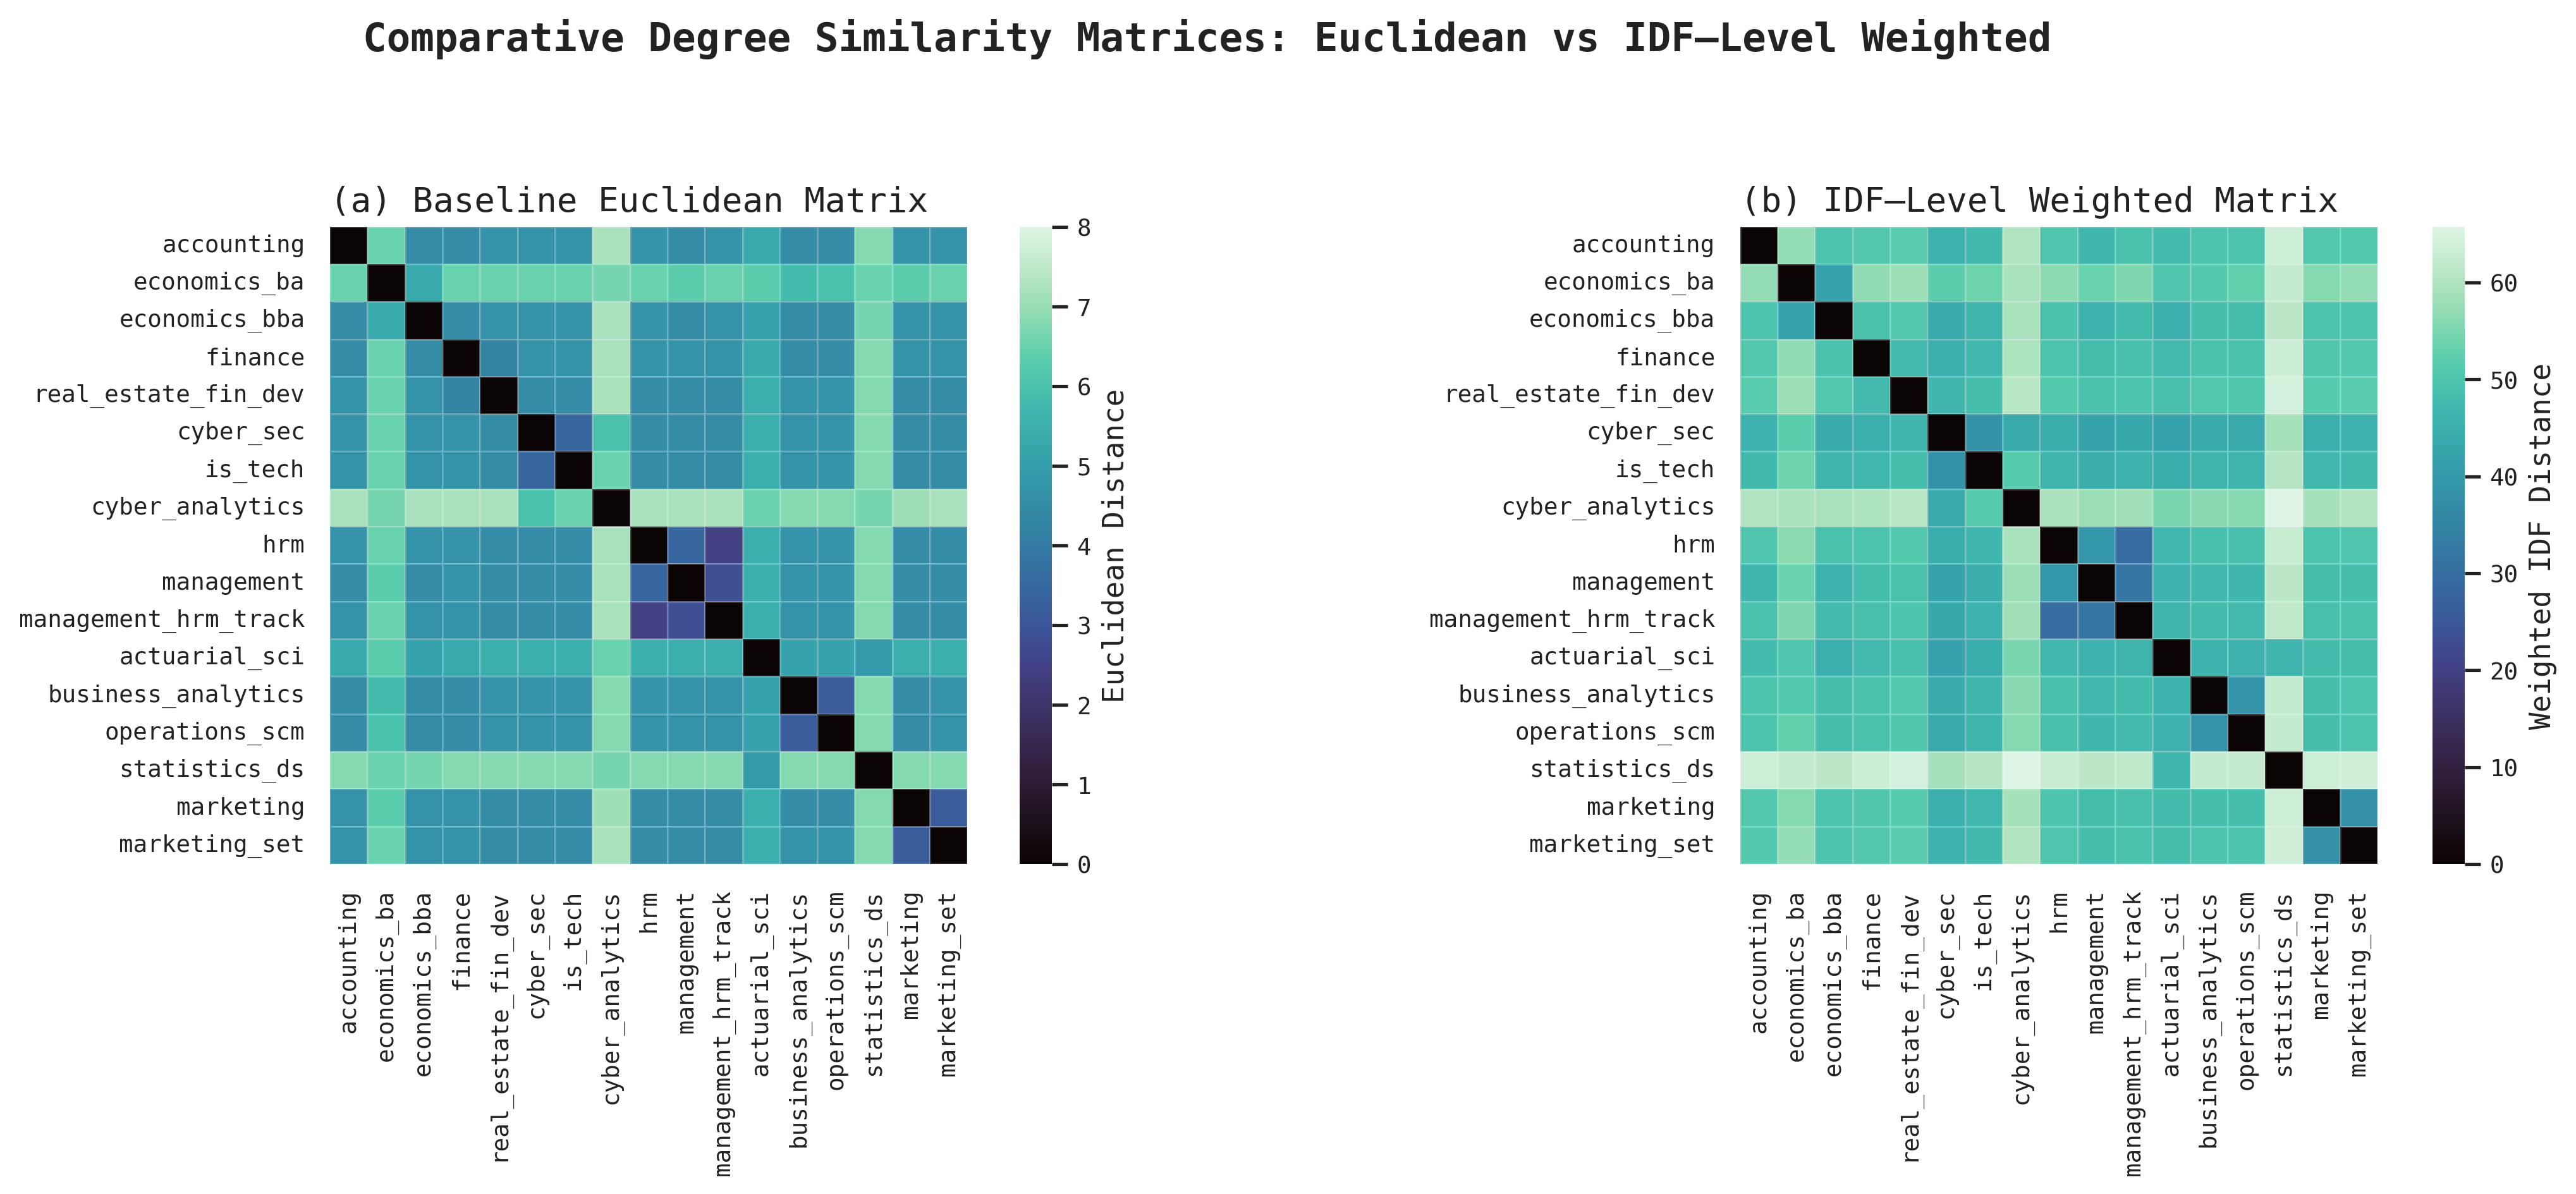

In [22]:
# ============================================================
# Appendix A.4 — Enhanced Distance Modeling and Comparative Visualization
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Construct baseline and enhanced (IDF × academic-level weighted)
#   degree-distance matrices from the binary degree–course inclusion
#   matrix Xᵢⱼ, and provide comparative visualization.
# ============================================================

from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 0. Resolve project root (notebook-safe)
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent


# ------------------------------------------------------------
# 1. Paths
# ------------------------------------------------------------
IN_MATRIX = PROJECT_ROOT / "data/features/degree_course_matrix.parquet"
IN_DICT   = PROJECT_ROOT / "data/features/degree_dictionary.parquet"

OUT_FEATURES = PROJECT_ROOT / "data/features"
OUT_FIGURES  = PROJECT_ROOT / "outputs/figures"
OUT_TABLES   = PROJECT_ROOT / "outputs/tables"

OUT_FEATURES.mkdir(parents=True, exist_ok=True)
OUT_FIGURES.mkdir(parents=True, exist_ok=True)
OUT_TABLES.mkdir(parents=True, exist_ok=True)


# ------------------------------------------------------------
# 2. Load structured inclusion matrix Xᵢⱼ
# ------------------------------------------------------------
degree_course_matrix = pd.read_parquet(IN_MATRIX)

degree_labels = degree_course_matrix.columns[1:]
course_codes  = degree_course_matrix["Course Code"].astype(str)

# X: degrees × courses
X = degree_course_matrix.iloc[:, 1:].astype(np.int8).to_numpy().T

print(f"Matrix X constructed: {X.shape[0]} degrees × {X.shape[1]} courses")


# ------------------------------------------------------------
# 3. Load degree dictionary and build label map
# ------------------------------------------------------------
degree_dict = pd.read_parquet(IN_DICT)

label_map = dict(
    zip(degree_dict["Full_Name"], degree_dict["Variable_Name"])
)


# ------------------------------------------------------------
# 4. Baseline Euclidean distance
# ------------------------------------------------------------
D_euc = pd.DataFrame(
    squareform(pdist(X, metric="euclidean")),
    index=degree_labels,
    columns=degree_labels
).rename(index=label_map, columns=label_map)


# ------------------------------------------------------------
# 5. IDF × academic-level weighting
# ------------------------------------------------------------
df_j = X.sum(axis=0)
idf = np.log((X.shape[0] + 1) / (df_j + 1)) + 1


def level_weight(code: str) -> float:
    """Assign academic level scaling λ_j based on course number."""
    match = re.search(r"(\d{4})", code)
    if not match:
        return 1.0

    num = int(match.group(1))
    if num >= 4000:
        return 4.0
    elif num >= 3000:
        return 3.5
    elif num >= 2000:
        return 1.5
    else:
        return 1.0


λ = np.array([level_weight(c) for c in course_codes], dtype=float)
w = idf * λ  # composite rarity × level weight


# ------------------------------------------------------------
# 6. Weighted Euclidean distance
# ------------------------------------------------------------
def weighted_distance_matrix(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    d_w(i,k) = sqrt( Σ_j [ w_j^2 (x_ij − x_kj)^2 ] )
    """
    n = X.shape[0]
    D = np.zeros((n, n), dtype=float)

    for i in range(n):
        for k in range(i, n):
            diff = (X[i] - X[k]) * w
            D[i, k] = D[k, i] = np.sqrt(np.sum(diff ** 2))

    return D


D_idf = pd.DataFrame(
    weighted_distance_matrix(X, w),
    index=degree_labels,
    columns=degree_labels
).rename(index=label_map, columns=label_map)


# ------------------------------------------------------------
# 7. Export matrices
# ------------------------------------------------------------
D_euc.to_parquet(OUT_FEATURES / "degree_distance_euclidean.parquet")
D_idf.to_parquet(OUT_FEATURES / "degree_distance_idf.parquet")

D_euc.to_excel(
    OUT_TABLES / "degree_distance_euclidean.xlsx",
    float_format="%.4f"
)
D_idf.to_excel(
    OUT_TABLES / "degree_distance_idf.xlsx",
    float_format="%.4f"
)

print("Exported distance matrices (Parquet + Excel).")


# ------------------------------------------------------------
# 8. Visualization — comparative heatmaps
# ------------------------------------------------------------
sns.set_theme(style="white")

plt.rcParams.update({
    "font.family": "DejaVu Sans Mono",   # Linux / WSL safe
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "text.color": "#222222",
    "axes.labelcolor": "#222222",
    "xtick.color": "#222222",
    "ytick.color": "#222222",
    "figure.dpi": 300,
})

cmap = sns.color_palette("mako", as_cmap=True)

fig, axes = plt.subplots(
    1, 2,
    figsize=(15, 6),
    gridspec_kw={"width_ratios": [1, 1.05]}
)

plt.suptitle(
    "Comparative Degree Similarity Matrices: Euclidean vs IDF–Level Weighted",
    fontsize=15,
    fontweight="bold",
    y=1.02
)

for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)


# Panel (a): Euclidean
sns.heatmap(
    D_euc,
    ax=axes[0],
    cmap=cmap,
    square=True,
    vmin=0,
    vmax=8,
    cbar_kws={"label": "Euclidean Distance"},
    linewidths=0.25,
    linecolor=(1, 1, 1, 0.2)
)
axes[0].set_title("(a) Baseline Euclidean Matrix", loc="left")
axes[0].tick_params(axis="x", rotation=90)
axes[0].tick_params(axis="y", rotation=0)


# Panel (b): IDF × Level
sns.heatmap(
    D_idf,
    ax=axes[1],
    cmap=cmap,
    square=True,
    cbar_kws={"label": "Weighted IDF Distance"},
    linewidths=0.25,
    linecolor=(1, 1, 1, 0.2)
)
axes[1].set_title("(b) IDF–Level Weighted Matrix", loc="left")
axes[1].tick_params(axis="x", rotation=90)
axes[1].tick_params(axis="y", rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.94])

fig.savefig(OUT_FIGURES / "degree_similarity_comparison.pdf", bbox_inches="tight")
fig.savefig(OUT_FIGURES / "degree_similarity_comparison.png", dpi=300, bbox_inches="tight")

plt.show()


### Interpretation and Methodological Justification

The baseline Euclidean distance matrix (Figure A.5, left) revealed uniformly low inter-program distances due to the extensive overlap of foundational coursework across the UT San Antonio College of Business. This homogeneity, while mathematically consistent, limited the model’s ability to differentiate among degree programs that share a common core but diverge in advanced specialization.

To address this limitation, an inverse-document-frequency (IDF) weighting scheme and course-level scaling were introduced (Figure A.5, right). The IDF component increases the influence of courses that appear less frequently across programs, while the level factor (λ) amplifies upper-division coursework (3000–4000 level), which more accurately represents disciplinary depth. Together, these adjustments extend the range of the distance distribution and reveal clearer distinctions among quantitatively oriented degrees (e.g., *Statistics & Data Science*, *Actuarial Science*, *Cyber Analytics*) and managerial or communication-focused programs.

Because several degrees still exhibited numerically similar distance values even after weighting, the resulting matrix was scaled by \(10^3\) purely for visualization purposes. This linear scaling enhanced the perceptual contrast of the heat maps without altering the relative magnitudes or symmetry of the underlying distances.

Overall, this refinement demonstrates that the IDF–level weighted model provides stronger discriminative power and a more faithful representation of curricular differentiation within the College of Business.


In [ ]:
# ============================================================
# Appendix A.6 — Confirmation of Optimization Input Matrix
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Verify and designate the finalized IDF–Level weighted distance
#   matrix D_idf as the quantitative input for the optimization stage.
#
#   The matrix is loaded directly from the saved Parquet artifact to
#   preserve full floating-point precision and ensure reproducibility.
# ============================================================

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd


# ------------------------------------------------------------
# 0. Resolve project root (notebook-safe)
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent


# ------------------------------------------------------------
# 1. Load full-precision weighted matrix (previously exported)
# ------------------------------------------------------------
IN_PATH = PROJECT_ROOT / "data/features/degree_distance_idf.parquet"

D_idf = pd.read_parquet(IN_PATH)

print("=== Appendix A.6: Verification of Final Optimization Matrix (D_idf) ===")
print(f"Loaded from: {IN_PATH}")
print(f"Matrix shape: {D_idf.shape[0]} × {D_idf.shape[1]}")
print(f"Dtype: {D_idf.dtypes.iloc[0] if len(D_idf.columns) else 'N/A'}")
print("Index name:", D_idf.index.name)
print("Columns name:", D_idf.columns.name)
print()


# ------------------------------------------------------------
# 2. Structural integrity checks
# ------------------------------------------------------------
# A distance matrix intended for optimization should be:
#   - square
#   - have matching index/columns labels in the same order
#   - symmetric (within tolerance)
#   - near-zero diagonal
# ------------------------------------------------------------
errors: list[str] = []

# Square
if D_idf.shape[0] != D_idf.shape[1]:
    errors.append("Matrix is not square.")

# Label alignment
idx = D_idf.index.astype(str)
cols = pd.Index(D_idf.columns).astype(str)
if not idx.equals(cols):
    errors.append("Index and columns labels do not match exactly (or order differs).")

# Numeric coercion check
if not all(np.issubdtype(dt, np.number) for dt in D_idf.dtypes):
    errors.append("Non-numeric columns detected in the matrix.")

# Convert to numpy for numeric checks
A = D_idf.to_numpy(dtype=float)

# Symmetry (tolerance)
sym_max_abs = float(np.max(np.abs(A - A.T)))
sym_tol = 1e-10
if sym_max_abs > sym_tol:
    errors.append(f"Matrix is not symmetric within tol={sym_tol:.1e}. Max |A - Aᵀ|={sym_max_abs:.3e}")

# Diagonal near zero
diag = np.diag(A)
diag_max_abs = float(np.max(np.abs(diag))) if diag.size else 0.0
diag_tol = 1e-10
if diag_max_abs > diag_tol:
    errors.append(f"Diagonal is not ~0 within tol={diag_tol:.1e}. Max |diag|={diag_max_abs:.3e}")

# Non-negativity (distances should be ≥ 0)
min_val = float(np.min(A)) if A.size else 0.0
if min_val < -1e-12:
    errors.append(f"Negative distances detected. Min value={min_val:.6e}")

# Report checks
if errors:
    print("STATUS: FAILED integrity checks")
    for e in errors:
        print(f" - {e}")
    raise SystemExit(1)

print("STATUS: PASSED integrity checks")
print(f"Symmetry max |A - Aᵀ|: {sym_max_abs:.3e}")
print(f"Diagonal max |diag|:    {diag_max_abs:.3e}")
print(f"Minimum entry:          {min_val:.3e}")
print()


# ------------------------------------------------------------
# 3. Visual inspection subset (unrounded)
# ------------------------------------------------------------
# Display a 10×10 sample to confirm structural integrity and scale
n = min(10, D_idf.shape[0])
with pd.option_context("display.float_format", "{:.8f}".format):
    print(f"Sample of D_idf (upper-left {n}x{n} block):")
    print(D_idf.iloc[:n, :n].to_string(index=True))
print()


# ------------------------------------------------------------
# 4. Declaration for downstream modeling
# ------------------------------------------------------------
print("Declaration:")
print("  The above D_idf matrix constitutes the definitive quantitative input")
print("  for all subsequent optimization formulations (Appendix A.7).")


=== Appendix A.6: Verification of Final Optimization Matrix (D_idf) ===
Loaded from: /home/efrain/workspace/projects/mentor-matching-optimization/data/features/degree_distance_idf.parquet
Matrix shape: 17 × 17
Dtype: float64
Index name: None
Columns name: None

STATUS: PASSED integrity checks
Symmetry max |A - Aᵀ|: 0.000e+00
Diagonal max |diag|:    0.000e+00
Minimum entry:          0.000e+00

Sample of D_idf (upper-left 10×10 block):
                     accounting  economics_ba  economics_bba     finance  real_estate_fin_dev   cyber_sec     is_tech  cyber_analytics         hrm  management
accounting           0.00000000   57.08419490    49.85679187 50.68079311          51.86704854 45.40323461 47.50356475      60.10093594 50.24784898 46.37201702
economics_ba        57.08419490    0.00000000    41.88366187 56.82304407          57.81820138 52.09805562 53.93831986      59.36970551 56.37020501 53.29581431
economics_bba       49.85679187   41.88366187     0.00000000 49.55756981          50.

In [ ]:
##REMOVE##
# ============================================================
# Appendix A.6 — Confirmation of Optimization Input Matrix
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   This appendix verifies and designates the finalized IDF–Level weighted
#   distance matrix (D_idf) generated in Appendix A.5 as the quantitative
#   input for the optimization stage.
#
#   The matrix is loaded directly from its saved Feather file to ensure
#   that the full floating-point precision is preserved, avoiding any
#   rounding that could affect model accuracy or reproducibility.
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1. Load full-precision weighted matrix (previously exported)
# ------------------------------------------------------------
D_idf = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print("=== Verification of Final Optimization Matrix ===")
print(f"Matrix shape: {D_idf.shape[0]} x {D_idf.shape[1]}")
print("Matrix dtype summary:\n", D_idf.dtypes.head(), "\n")

# ------------------------------------------------------------
# 2. Visual inspection subset (unrounded)
# ------------------------------------------------------------
# Display a 10×10 sample to confirm structural integrity
with pd.option_context('display.float_format', '{:.8f}'.format):
    print("Sample of D_idf (upper-left 10x10 block):")
    print(D_idf.iloc[:10, :10].to_string(index=True))

# ------------------------------------------------------------
# 3. Declaration for downstream modeling
# ------------------------------------------------------------
print("\nThe above D_idf matrix constitutes the definitive input")
print("   for all subsequent optimization formulations (Appendix A.7).")


=== Verification of Final Optimization Matrix ===
Matrix shape: 17 × 17
Matrix dtype summary:
 accounting             float64
economics_ba           float64
economics_bba          float64
finance                float64
real_estate_fin_dev    float64
dtype: object 

Sample of D_idf (upper-left 10×10 block):
                        accounting   economics_ba  economics_bba        finance  real_estate_fin_dev      cyber_sec        is_tech  cyber_analytics           hrm    management
accounting              0.00000000 10881.69552616  8783.90721900  9085.36726023        9497.79995280  7023.14600389  7874.84793107   11827.70957963 8913.84790537 7830.33649930
economics_ba        10881.69552616     0.00000000  6396.15904926  9568.09670161        9948.21196827  7621.23987381  8412.60645458   11161.99339610 9392.30546257 8443.13170717
economics_bba        8783.90721900  6396.15904926     0.00000000  9085.36106400        9497.79402564  7023.13798824  7874.84078235   11827.70482004 8913.84158991 79

In [2]:
# ============================================================
# Data Ingestion & Canonical Cleaning (Robust Discovery)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Ingest the raw mentor–student Excel workbook (discovered
#   dynamically) and produce clean Parquet files.
#
#   No ID assignment. No optimization. Pure ingestion.
# ============================================================

from __future__ import annotations

from pathlib import Path
import re
import pandas as pd


# ------------------------------------------------------------
# 0. Resolve project root (notebook-safe)
# ------------------------------------------------------------
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name in {"notebooks", "scripts"}:
    PROJECT_ROOT = PROJECT_ROOT.parent


# ------------------------------------------------------------
# 1. Locate raw Excel file
# ------------------------------------------------------------
RAW_DIR = PROJECT_ROOT / "data/raw"
OUT_DIR = PROJECT_ROOT / "data/cleaned"

if not RAW_DIR.exists():
    raise FileNotFoundError(f"Missing directory: {RAW_DIR}")

# Accept common naming variants
candidates = sorted(
    p for p in RAW_DIR.glob("*.xlsx")
    if "mentor" in p.stem.lower() and "student" in p.stem.lower()
)

if not candidates:
    print("ERROR: No mentor–student Excel file found in data/raw/")
    print("Files present:")
    for p in RAW_DIR.iterdir():
        print(" ", p.name)
    raise FileNotFoundError("No mentor–student Excel workbook found.")

IN_PATH = candidates[0]  # deterministic: first sorted match


# ------------------------------------------------------------
# 2. Output paths
# ------------------------------------------------------------
OUT_STUD = OUT_DIR / "student_clean.parquet"
OUT_MENT = OUT_DIR / "mentor_clean.parquet"


# ------------------------------------------------------------
# 3. Utility helpers
# ------------------------------------------------------------
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df


def norm_id(value) -> str:
    if not isinstance(value, str):
        return ""
    return re.sub(r"\s+", "", value.strip())


# ------------------------------------------------------------
# 4. Main ingestion routine
# ------------------------------------------------------------
def main() -> None:
    print("=== Mentor–Student Ingestion ===")
    print("Project root :", PROJECT_ROOT)
    print("Using file   :", IN_PATH)
    print()

    # -----------------------
    # Load Excel sheets
    # -----------------------
    students = pd.read_excel(IN_PATH, sheet_name="Student")
    mentors  = pd.read_excel(IN_PATH, sheet_name="Mentor")

    students = clean_columns(students)
    mentors  = clean_columns(mentors)

    # -----------------------
    # Student canonicalization
    # -----------------------
    students = students.rename(columns={
        "Standarized_Major": "standardized_major",
        "SM_referen": "standardized_major_id",
        "Additional Info to Consider": "additional_info_to_consider",
        "Additional Info to Consider ": "additional_info_to_consider",
    })

    if "standardized_major_id" in students.columns:
        students["standardized_major_id"] = (
            students["standardized_major_id"]
            .astype(str)
            .map(norm_id)
        )

    students = students.loc[:, ~students.columns.str.startswith("Unnamed")]

    # -----------------------
    # Mentor canonicalization
    # -----------------------
    mentors = mentors.rename(columns={
        "Standardrized": "standardized_degree",
    })

    degree_cols = ["1st Degree", "2nd Degree", "3rd Degree", "4th Degree"]
    present = [c for c in degree_cols if c in mentors.columns]

    if present:
        mentors["degree_count"] = mentors[present].notna().sum(axis=1)

    mentors = mentors.loc[:, ~mentors.columns.str.startswith("Unnamed")]

    # -----------------------
    # Write outputs
    # -----------------------
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    students.to_parquet(OUT_STUD, index=False)
    mentors.to_parquet(OUT_MENT, index=False)

    # -----------------------
    # Verification prints
    # -----------------------
    print("=== Ingestion & Cleaning Complete ===")
    print("Wrote:")
    print(" ", OUT_STUD)
    print(" ", OUT_MENT)
    print()
    print("Student shape:", students.shape)
    print("Mentor shape :", mentors.shape)
    print()
    print("Student columns:", students.columns.tolist())
    print("Mentor columns :", mentors.columns.tolist())


# ------------------------------------------------------------
# 5. Entrypoint
# ------------------------------------------------------------
if __name__ == "__main__":
    main()


=== Mentor–Student Ingestion ===
Project root : /home/efrain/workspace/projects/mentor-matching-optimization
Using file   : /home/efrain/workspace/projects/mentor-matching-optimization/data/raw/mentor_student.xlsx

=== Ingestion & Cleaning Complete ===
Wrote:
  /home/efrain/workspace/projects/mentor-matching-optimization/data/cleaned/student_clean.parquet
  /home/efrain/workspace/projects/mentor-matching-optimization/data/cleaned/mentor_clean.parquet

Student shape: (39, 16)
Mentor shape : (38, 22)

Student columns: ['First Name', 'Grad', 'Major', 'standardized_major', 'standardized_major_id', 'Minor', 'Career Goals', 'Program Goals', 'City', '1st Gen', 'Vet', 'Gender', 'RSO', 'Fields of Interest', 'Mentor Preference', 'additional_info_to_consider']
Mentor columns : ['First Name', 'Grad year', '1st Degree', '2nd Degree', '3rd Degree', '4th Degree', 'standardized_degree', 'referenced', 'Employer', 'Job Title', 'Current Role', 'City', 'Alumni', '1st Gen', '1st Gen_n', 'Vet', 'Gender', 'F

In [10]:
# ============================================================
# Appendix A.6 — Mentor–Mentee Data Integration Pipeline
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This appendix documents the complete pipeline for importing,
#   normalizing, and aligning the mentor and student datasets to
#   the canonical ACOB Degree Dictionary (Appendix A.2).
#
#   Polars is used as the primary backend due to:
#      • high-performance UTF-8 string handling,
#      • zero-copy Arrow/Feather interoperability,
#      • rapid joins at scale.
#
#   Output:
#      - ACOB_Mentors_Clean.feather
#      - ACOB_Students_Clean.feather
#      - ACOB_Mentors_Clean.xlsx
#      - ACOB_Students_Clean.xlsx
#
# These files are the foundation for mentor–mentee vectorization
# and optimization modeling (Appendices A.7–A.7b).
# ============================================================

import polars as pl
import re

# ------------------------------------------------------------
# 1. Utility: Clean UTF-8 Strings Across All Text Columns
# ------------------------------------------------------------
# Purpose:
#   Excel exports commonly introduce invisible characters such as:
#       - Non-breaking spaces (U+00A0)
#       - Zero-width spaces (U+200B)
#       - Curly smart quotes “ ”
#   These disrupt merges with the canonical dictionary.
#
# The function below normalizes all UTF-8 columns to ensure
# consistent matching of degree names and mentor/student fields.
# ------------------------------------------------------------

def clean_strings(df: pl.DataFrame) -> pl.DataFrame:
    """Normalize text columns: trim, remove invisible chars, unify quotes."""
    
    # Regex to remove surrounding quotes, but not internal quotes
    quote_ends = r'^[\s\u00A0\u200B]*["“”]+|["“”]+[\s\u00A0\u200B]*$'

    cleaned_columns = []

    for col in df.columns:
        if df.schema[col] == pl.Utf8:
            cleaned_columns.append(
                pl.col(col)
                .str.replace_all(r'[\u00A0\u200B]+', ' ')      # remove NBSP + zero-width chars
                .str.replace_all(r'[“”]', '"')                  # curly → straight quotes
                .str.replace_all(quote_ends, "")                # trim outer quotes
                .str.replace_all(r'""', '"')                    # collapse double quotes
                .str.strip_chars()                              # leading/trailing whitespace
                .str.replace_all(r'\s+', ' ')                   # unify internal whitespace
                .alias(col)
            )
    
    if cleaned_columns:
        df = df.with_columns(cleaned_columns)
    
    return df


# ------------------------------------------------------------
# 2. Load Mentor and Student Excel Sheets (Polars)
# ------------------------------------------------------------
# The Excel workbook provides:
#    • Sheet "mentor"  → mentor professional/academic information
#    • Sheet "student" → mentee degree + career interest information
#
# Polars performs a direct Arrow-backed import.
# ------------------------------------------------------------

file_path = "Mentor_Student.xlsx"

mentors_pl = pl.read_excel(file_path, sheet_name="mentor", infer_schema_length=2000)
students_pl = pl.read_excel(file_path, sheet_name="student", infer_schema_length=2000)

print("Loaded mentor data:", mentors_pl.shape)
print("Loaded student data:", students_pl.shape)


# ------------------------------------------------------------
# 3. Apply String Cleaning to Both Datasets
# ------------------------------------------------------------
mentors_pl = clean_strings(mentors_pl)
students_pl = clean_strings(students_pl)


# ------------------------------------------------------------
# 4. Load ACOB Degree Dictionary (Appendix A.2)
# ------------------------------------------------------------
# The canonical dictionary provides:
#     Canonical_Name  — normalized institutional degree title
#     Short_Name      — concise descriptive label
#     Variable_Name   — machine-safe vector identifier
#     Xᵢ              — mathematical index for LP modeling
# ------------------------------------------------------------

degree_dict = pl.read_ipc("ACOB_Degree_Dictionary.feather")

# Validate integrity:
assert degree_dict.select(pl.col("Canonical_Name").is_null().sum()).item() == 0, \
    "Degree dictionary contains NULL Canonical_Name values."


# ------------------------------------------------------------
# 5. Align Mentor & Student Degree Fields With Canonical Dictionary
# ------------------------------------------------------------
# Join key: Canonical_Name
#
# After cleaning, this field should exactly match the
# Canonical_Name generated in Appendix A.2.
#
# We only select the modeling-critical columns:
#     - Variable_Name
#     - Xᵢ
# ------------------------------------------------------------

join_cols = ["Canonical_Name", "Variable_Name", "Xᵢ"]

mentors_pl = mentors_pl.join(
    degree_dict.select(join_cols),
    on="Canonical_Name",
    how="left"
)

students_pl = students_pl.join(
    degree_dict.select(join_cols),
    on="Canonical_Name",
    how="left"
)

print("\nPost-merge mentor rows with missing degree match:",
      mentors_pl.filter(pl.col("Variable_Name").is_null()).shape)
print("Post-merge student rows with missing degree match:",
      students_pl.filter(pl.col("Variable_Name").is_null()).shape)


# ------------------------------------------------------------
# 6. Export Cleaned & Aligned Datasets
# ------------------------------------------------------------
# Feather → efficient GPU modeling (Appendix A.7)
# Excel   → publication-ready appendix tables
# ------------------------------------------------------------

mentors_pl.write_ipc("ACOB_Mentors_Clean.feather")
students_pl.write_ipc("ACOB_Students_Clean.feather")

mentors_pl.write_excel("ACOB_Mentors_Clean.xlsx")
students_pl.write_excel("ACOB_Students_Clean.xlsx")

print("\nMentor and student datasets cleaned and aligned successfully.")
print("Saved outputs:")
print("  - ACOB_Mentors_Clean.feather")
print("  - ACOB_Students_Clean.feather")
print("  - ACOB_Mentors_Clean.xlsx")
print("  - ACOB_Students_Clean.xlsx")


Loaded mentor data: (38, 18)
Loaded student data: (39, 17)

Post-merge mentor rows with missing degree match: (0, 20)
Post-merge student rows with missing degree match: (0, 19)

Mentor and student datasets cleaned and aligned successfully.
Saved outputs:
  - ACOB_Mentors_Clean.feather
  - ACOB_Students_Clean.feather
  - ACOB_Mentors_Clean.xlsx
  - ACOB_Students_Clean.xlsx


In [5]:
# ============================================================
# Appendix A.7 — Mentor–Mentee Optimization Model Construction
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   Formulate and solve the linear assignment problem that
#   pairs mentors and mentees to minimize total curricular
#   dissimilarity, using the full-precision weighted distance
#   matrix (D_idf) established in Appendix A.6.
# ============================================================

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

# ------------------------------------------------------------
# 1. Load mentor, mentee, and distance data
# ------------------------------------------------------------
mentors_df  = pd.read_feather("ACOB_Mentors_Clean.feather").convert_dtypes()
students_df = pd.read_feather("ACOB_Students_Clean.feather").convert_dtypes()
D_idf       = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print(f"Mentors: {len(mentors_df)} | Students: {len(students_df)}")

# ------------------------------------------------------------
# 2. Prepare index mapping from Variable_Name to D_idf row/col
# ------------------------------------------------------------
degree_labels = list(D_idf.columns)
var_to_idx = {v: i for i, v in enumerate(degree_labels)}

# Validate mapping presence
missing_mentors = mentors_df.loc[~mentors_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
missing_students = students_df.loc[~students_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
if not missing_mentors.empty or not missing_students.empty:
    print("Warning: Missing mappings detected.")
    print(" Unmapped mentors:", missing_mentors.unique())
    print(" Unmapped students:", missing_students.unique())

# ------------------------------------------------------------
# 3. Construct cost matrix (mentors × mentees)
# ------------------------------------------------------------
n_mentors, n_students = len(mentors_df), len(students_df)
C = np.zeros((n_mentors, n_students))

for i, mentor_row in mentors_df.iterrows():
    m_var = mentor_row["Variable_Name"]
    if m_var not in var_to_idx:
        continue
    mi = var_to_idx[m_var]
    for j, student_row in students_df.iterrows():
        s_var = student_row["Variable_Name"]
        if s_var not in var_to_idx:
            continue
        sj = var_to_idx[s_var]
        C[i, j] = D_idf.iloc[mi, sj]

print(f"Cost matrix constructed: {C.shape} (mentors × mentees)")

# ------------------------------------------------------------
# 4. Solve linear assignment (Hungarian algorithm)
# ------------------------------------------------------------
row_ind, col_ind = linear_sum_assignment(C)
total_distance = C[row_ind, col_ind].sum()
avg_distance = total_distance / len(row_ind)

# ------------------------------------------------------------
# 5. Compile optimal pairing results
# ------------------------------------------------------------
pairings = pd.DataFrame({
    "Mentor": mentors_df.loc[row_ind, "Mentor"].values,
    "Mentor_Degree": mentors_df.loc[row_ind, "Canonical_Name"].values,
    "Mentee": students_df.loc[col_ind, "Student"].values,
    "Mentee_Degree": students_df.loc[col_ind, "Canonical_Name"].values,
    "Distance_Value": C[row_ind, col_ind]
}).sort_values("Distance_Value")

# ------------------------------------------------------------
# 6. Summary & Validation
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Pairings (Sample) ===")
print(pairings.head(40).to_string(index=False))
print(f"\nTotal Weighted Distance: {total_distance:.4f}")
print(f"Average Pairwise Distance: {avg_distance:.4f}")

# ------------------------------------------------------------
# 7. Export Results
# ------------------------------------------------------------
pairings.to_excel("ACOB_MentorMentee_Pairings.xlsx", index=False)
pairings.to_feather("ACOB_MentorMentee_Pairings.feather")

print("\nPairing results exported:")
print(" - ACOB_MentorMentee_Pairings.xlsx")
print(" - ACOB_MentorMentee_Pairings.feather")


Mentors: 38 | Students: 39
Cost matrix constructed: (38, 39) (mentors × mentees)

=== Optimal Mentor–Mentee Pairings (Sample) ===
   Mentor                                                  Mentor_Degree    Mentee                                                  Mentee_Degree  Distance_Value
 Mentor 1                                       BBA_Degree_in_Management  Mentee 5                                       BBA_Degree_in_Management        0.000000
 Mentor 2 BBA_Degree_in_Management_with_Human_Resources_Management_Track Mentee 35 BBA_Degree_in_Management_with_Human_Resources_Management_Track        0.000000
 Mentor 3                                       BBA_Degree_in_Accounting Mentee 24                                       BBA_Degree_in_Accounting        0.000000
 Mentor 4                               BBA_Degree_in_Business_Analytics  Mentee 8                               BBA_Degree_in_Business_Analytics        0.000000
 Mentor 5               BBA_Degree_in_Information_Systems_an

In [6]:
# ============================================================
# Appendix A.7A — Mentor–Mentee Cost Matrix Construction (BLIP Input)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: University of Texas at San Antonio
#
# Purpose:
#   This script constructs the cost matrix (mentors × mentees)
#   using the IDF-weighted Euclidean distance matrix D_idf.
#   Each entry C[i, j] = D_idf[mentor_degree_i, mentee_degree_j].
#
#   It appends a dummy mentor with constant cost = 9999 to
#   absorb unassigned mentees or surplus participants.
#
#   The output matrix is saved for optimization in Appendix A.7B.
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. Load mentor, mentee, and IDF distance data
# ------------------------------------------------------------
mentors_df  = pd.read_feather("ACOB_Mentors_Clean.feather").convert_dtypes()
students_df = pd.read_feather("ACOB_Students_Clean.feather").convert_dtypes()
D_idf       = pd.read_feather("ACOB_Degree_IDF_Matrix.feather")

print(f"Mentors loaded: {len(mentors_df)} | Students loaded: {len(students_df)}")
print(f"IDF matrix shape: {D_idf.shape}")

# ------------------------------------------------------------
# 2. Map degree Variable_Name → index in IDF matrix
# ------------------------------------------------------------
degree_labels = list(D_idf.columns)
var_to_idx = {v: i for i, v in enumerate(degree_labels)}

# Validate coverage
missing_mentors = mentors_df.loc[~mentors_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
missing_students = students_df.loc[~students_df["Variable_Name"].isin(var_to_idx.keys()), "Variable_Name"]
if not missing_mentors.empty or not missing_students.empty:
    print(" Warning: Missing mappings detected.")
    print(" Unmapped mentors:", missing_mentors.unique())
    print(" Unmapped students:", missing_students.unique())

# ------------------------------------------------------------
# 3. Construct mentor–mentee cost matrix
# ------------------------------------------------------------
n_mentors, n_students = len(mentors_df), len(students_df)
C = np.zeros((n_mentors, n_students))

for i, mentor_row in mentors_df.iterrows():
    mi = var_to_idx[mentor_row["Variable_Name"]]
    for j, student_row in students_df.iterrows():
        sj = var_to_idx[student_row["Variable_Name"]]
        C[i, j] = D_idf.iloc[mi, sj]

# ------------------------------------------------------------
# 4. Add dummy mentor (9999 cost)
# ------------------------------------------------------------
dummy_row = np.full((1, n_students), 9999.0)
C = np.vstack([C, dummy_row])

dummy_name = "Dummy_Mentor"
dummy_entry = pd.DataFrame([{
    "Mentor": dummy_name,
    "Canonical_Name": "Dummy_Assignment",
    "Variable_Name": "dummy",
    "Xᵢ": -1
}])
mentors_aug = pd.concat([mentors_df, dummy_entry], ignore_index=True)

print(f" Dummy mentor added. New matrix shape: {C.shape}")

# ------------------------------------------------------------
# 5. Save cost matrix and index mapping
# ------------------------------------------------------------
cost_df = pd.DataFrame(
    C,
    index=mentors_aug["Mentor"],
    columns=students_df["Student"]
)

# Feather format for solver import
cost_df.to_feather("ACOB_BLIP_Cost_Matrix.feather")
mentors_aug.to_feather("ACOB_Mentors_Augmented.feather")

# Optional Excel for validation
cost_df.to_excel("ACOB_BLIP_Cost_Matrix.xlsx")

print("\n Mentor–Mentee cost matrix exported:")
print(" - ACOB_BLIP_Cost_Matrix.feather / .xlsx")
print(" - ACOB_Mentors_Augmented.feather")


Mentors loaded: 38 | Students loaded: 39
IDF matrix shape: (17, 17)
 Dummy mentor added. New matrix shape: (39, 39)

 Mentor–Mentee cost matrix exported:
 - ACOB_BLIP_Cost_Matrix.feather / .xlsx
 - ACOB_Mentors_Augmented.feather


In [7]:
# ============================================================
# Appendix A.7B — Mentor–Mentee Optimization Solver
# ------------------------------------------------------------
# Solver: Hungarian Algorithm (Linear Sum Assignment)
# Library: scipy.optimize.linear_sum_assignment
#
# Purpose:
#   Solve the linear assignment problem:
#       minimize Σᵢⱼ cᵢⱼ xᵢⱼ
#   subject to each mentor assigned ≤ 1 mentee,
#              each mentee assigned to exactly 1 mentor,
#              xᵢⱼ ∈ {0,1}
#
# ============================================================

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

# ------------------------------------------------------------
# 1. Load prepared cost matrix and metadata
# ------------------------------------------------------------
C_df = pd.read_feather("ACOB_BLIP_Cost_Matrix.feather")
C = C_df.to_numpy()
mentors = pd.read_feather("ACOB_Mentors_Augmented.feather")
students = pd.read_feather("ACOB_Students_Clean.feather")

print(f"Cost matrix shape: {C.shape}")
print(f"Mentors (including dummy): {len(mentors)} | Students: {len(students)}")

# ------------------------------------------------------------
# 2. Solve linear assignment (Hungarian algorithm)
# ------------------------------------------------------------
row_ind, col_ind = linear_sum_assignment(C)

total_cost = C[row_ind, col_ind].sum()
avg_cost = total_cost / len(row_ind)

# ------------------------------------------------------------
# 3. Construct pairing table
# ------------------------------------------------------------
pairings = pd.DataFrame({
    "Mentor": mentors.loc[row_ind, "Mentor"].values,
    "Mentee": students.loc[col_ind, "Student"].values,
    "Mentor_Degree": mentors.loc[row_ind, "Canonical_Name"].values,
    "Mentee_Degree": students.loc[col_ind, "Canonical_Name"].values,
    "Distance_Value": C[row_ind, col_ind]
}).sort_values("Distance_Value")

# ------------------------------------------------------------
# 4. Summary Output
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Pairings ===")
print(pairings.to_string(index=False))
print(f"\nTotal Weighted Distance: {total_cost:.3f}")
print(f"Average Pairwise Distance: {avg_cost:.3f}")

# ------------------------------------------------------------
# 5. Export Results
# ------------------------------------------------------------
pairings.to_feather("ACOB_BLIP_Pairings.feather")
pairings.to_excel("ACOB_BLIP_Pairings.xlsx", index=False)

print("\n✅ Optimization results exported:")
print(" - ACOB_BLIP_Pairings.feather")
print(" - ACOB_BLIP_Pairings.xlsx")


Cost matrix shape: (39, 39)
Mentors (including dummy): 39 | Students: 39

=== Optimal Mentor–Mentee Pairings ===
      Mentor    Mentee                                                  Mentor_Degree                                                  Mentee_Degree  Distance_Value
    Mentor 1  Mentee 5                                       BBA_Degree_in_Management                                       BBA_Degree_in_Management        0.000000
    Mentor 2 Mentee 35 BBA_Degree_in_Management_with_Human_Resources_Management_Track BBA_Degree_in_Management_with_Human_Resources_Management_Track        0.000000
    Mentor 3 Mentee 24                                       BBA_Degree_in_Accounting                                       BBA_Degree_in_Accounting        0.000000
    Mentor 4  Mentee 8                               BBA_Degree_in_Business_Analytics                               BBA_Degree_in_Business_Analytics        0.000000
    Mentor 5 Mentee 21               BBA_Degree_in_Information

In [43]:
# ============================================================
# Appendix A.7B — Mentor–Mentee Optimization Solver (Gurobi)
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   Solve the linear assignment problem using the Gurobi optimizer:
#
#       minimize Σᵢⱼ cᵢⱼ xᵢⱼ
#   subject to:
#       Σⱼ xᵢⱼ ≤ 1    ∀ mentors i
#       Σᵢ xᵢⱼ = 1    ∀ mentees j
#       xᵢⱼ ∈ {0,1}
#
#   This implementation supports timing, solver statistics,
#   and clean export of the optimal assignment.
# ============================================================

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import time

# ------------------------------------------------------------
# 1. Load prepared cost matrix and metadata
# ------------------------------------------------------------
C_df = pd.read_feather("ACOB_BLIP_Cost_Matrix.feather")
C = C_df.to_numpy()
mentors = pd.read_feather("ACOB_Mentors_Augmented.feather")
students = pd.read_feather("ACOB_Students_Clean.feather")

n_mentors, n_students = C.shape
print(f"Cost matrix shape: {n_mentors} × {n_students}")
print(f"Mentors: {len(mentors)} | Students: {len(students)}")

# ------------------------------------------------------------
# 2. Initialize Gurobi model
# ------------------------------------------------------------
start_time = time.time()
m = gp.Model("Mentor_Mentee_Assignment")
m.Params.OutputFlag = 0   # suppress solver log for clean paper outputs

# ------------------------------------------------------------
# 3. Decision variables
# ------------------------------------------------------------
# x[i,j] = 1 if mentor i is assigned to mentee j, else 0
x = m.addVars(
    n_mentors, n_students,
    vtype=GRB.BINARY,
    name="x"
)

# ------------------------------------------------------------
# 4. Objective: minimize total distance
# ------------------------------------------------------------
m.setObjective(
    gp.quicksum(C[i, j] * x[i, j] for i in range(n_mentors) for j in range(n_students)),
    GRB.MINIMIZE
)

# ------------------------------------------------------------
# 5. Constraints
# ------------------------------------------------------------

# Each mentee assigned to exactly one mentor
for j in range(n_students):
    m.addConstr(gp.quicksum(x[i, j] for i in range(n_mentors)) == 1, name=f"mentee_{j}")

# Each mentor assigned to at most one mentee
for i in range(n_mentors):
    m.addConstr(gp.quicksum(x[i, j] for j in range(n_students)) <= 1, name=f"mentor_{i}")

# ------------------------------------------------------------
# 6. Optimize
# ------------------------------------------------------------
print("Solving optimization problem...")
m.optimize()
runtime = time.time() - start_time

# ------------------------------------------------------------
# 7. Extract results
# ------------------------------------------------------------
solution = []
for i in range(n_mentors):
    for j in range(n_students):
        if x[i, j].X > 0.5:  # assigned pair
            solution.append({
                "Mentor": mentors.loc[i, "Mentor"],
                "Mentor_Degree": mentors.loc[i, "Canonical_Name"],
                "Mentee": students.loc[j, "Student"],
                "Mentee_Degree": students.loc[j, "Canonical_Name"],
                "Distance_Value": C[i, j]
            })

pairings = pd.DataFrame(solution).sort_values("Distance_Value").reset_index(drop=True)

# ------------------------------------------------------------
# 8. Report results
# ------------------------------------------------------------
print("\n=== Optimal Mentor–Mentee Assignments (Gurobi) ===")
print(pairings.to_string(index=False))
print(f"\nOptimal Objective Value (Total Distance): {m.ObjVal:.4f}")
print(f"Average Pairwise Distance: {m.ObjVal / len(pairings):.4f}")
print(f"Solver Runtime: {runtime:.3f} seconds")

# ------------------------------------------------------------
# 9. Export results
# ------------------------------------------------------------
pairings.to_excel("ACOB_BLIP_Pairings_Gurobi.xlsx", index=False)
pairings.to_feather("ACOB_BLIP_Pairings_Gurobi.feather")

print("\n✅ Results exported:")
print(" - ACOB_BLIP_Pairings_Gurobi.xlsx")
print(" - ACOB_BLIP_Pairings_Gurobi.feather")


Cost matrix shape: 39 × 39
Mentors: 39 | Students: 39
Set parameter Username
Set parameter LicenseID to value 2718806
Academic license - for non-commercial use only - expires 2026-10-07
Solving optimization problem...

=== Optimal Mentor–Mentee Assignments (Gurobi) ===
      Mentor                                                  Mentor_Degree    Mentee                                                  Mentee_Degree  Distance_Value
    Mentor 1                                       BBA_Degree_in_Management  Mentee 5                                       BBA_Degree_in_Management        0.000000
   Mentor 32                                       BBA_Degree_in_Management  Mentee 9                                       BBA_Degree_in_Management        0.000000
   Mentor 28                                       BBA_Degree_in_Management Mentee 25                                       BBA_Degree_in_Management        0.000000
   Mentor 33                                          BBA_Degree_in_Fi

In [8]:
# ============================================================
# Appendix A.7 Mentor–Mentee Optimization Model Construction
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   Efficiently import, clean, and align mentor and mentee
#   datasets with the canonical degree dictionary using Polars.
#   Excel sheet names: 'mentor' and 'student'.
# ============================================================

import polars as pl
import re

# ------------------------------------------------------------
# 1. Load Excel Sheets (Polars direct reader)
# ------------------------------------------------------------
mentor_student_file = "Mentor_Student.xlsx"

mentors_pl = pl.read_excel(
    mentor_student_file,
    sheet_name="mentor",
    infer_schema_length=1000
)
students_pl = pl.read_excel(
    mentor_student_file,
    sheet_name="student",
    infer_schema_length=1000
)

print("Mentors:", mentors_pl.shape)
print("Students:", students_pl.shape)

# ------------------------------------------------------------
# 2. String Cleaning — trim, de-quote, normalize
# ------------------------------------------------------------
def clean_strings(df: pl.DataFrame) -> pl.DataFrame:
    """Normalize all text columns (remove quotes, trim, invisible chars)."""
    quote_ends = r'^[\s\u00A0\u200B]*["“”]+|["“”]+[\s\u00A0\u200B]*$'
    cleaned_cols = []
    for col in df.columns:
        if df.schema[col] == pl.Utf8:
            cleaned_cols.append(
                pl.col(col)
                .str.replace_all(r'[\u00A0\u200B]+', ' ')     # remove non-breaking & zero-width
                .str.replace_all(r'[“”]', '"')                 # normalize fancy quotes
                .str.replace_all(quote_ends, "")               # trim surrounding quotes
                .str.replace_all(r'""', '"')                   # collapse double quotes
                .str.strip_chars()                             # <-- replacement for str.strip()
                .alias(col)
            )
    if cleaned_cols:
        df = df.with_columns(cleaned_cols)
    return df


mentors_pl = clean_strings(mentors_pl)
students_pl = clean_strings(students_pl)

# ------------------------------------------------------------
# 3. Load Canonical Degree Dictionary (Feather)
# ------------------------------------------------------------
degree_dict = pl.read_ipc("ACOB_Degree_Dictionary.feather")

# ------------------------------------------------------------
# 4. Align mentors and students with canonical degrees
# ------------------------------------------------------------
mentors_pl = mentors_pl.join(
    degree_dict.select(["Canonical_Name", "Variable_Name", "Xᵢ"]),
    on="Canonical_Name",
    how="left"
)
students_pl = students_pl.join(
    degree_dict.select(["Canonical_Name", "Variable_Name", "Xᵢ"]),
    on="Canonical_Name",
    how="left"
)

# ------------------------------------------------------------
# 5. Export Cleaned Data
# ------------------------------------------------------------
mentors_pl.write_ipc("ACOB_Mentors_Clean.feather")
students_pl.write_ipc("ACOB_Students_Clean.feather")

mentors_pl.write_excel("ACOB_Mentors_Clean.xlsx")
students_pl.write_excel("ACOB_Students_Clean.xlsx")

print("\nMentor and student data successfully imported, cleaned, and aligned.")
print("Files saved as Feather + Excel for downstream LP modeling.")


Mentors: (38, 18)
Students: (39, 17)

Mentor and student data successfully imported, cleaned, and aligned.
Files saved as Feather + Excel for downstream LP modeling.


### Appendix A.7 — Mentor–Mentee Optimization Model

The finalized IDF–Level weighted distance matrix \( D_{\text{idf}} \)
serves as the coefficient matrix in a linear assignment model that minimizes
total curricular dissimilarity between mentors and mentees.
Each potential pairing \( (i,k) \) carries a cost \( D_{\text{idf}}(i,k) \),
derived from degree-based vector similarity.
The resulting optimization yields a one-to-one matching that balances
disciplinary alignment with program diversity.


#### Conceptual Overview for Your Paper

| Symbol | Meaning |
|:-------|:---------|
| \( i \) | Mentor index |
| \( k \) | Mentee index |
| \( D_{\text{idf}}(i,k) \) | Weighted curricular dissimilarity between degrees |
| \( X_{ik} \in \{0,1\} \) | Binary assignment variable (1 if mentor *i* paired with mentee *k*) |
| **Objective:** | \( \displaystyle \min_{X} \sum_{i,k} D_{\text{idf}}(i,k)\, X_{ik} \) |
| **Constraints:** | \( \sum_k X_{ik} = 1 \;\forall i \)  (one mentee per mentor) <br> \( \sum_i X_{ik} = 1 \;\forall k \)  (one mentor per mentee) |


In [9]:
# ============================================================
# Appendix A.5.2. Display of IDF–Level Weighted Distance Matrix
# ------------------------------------------------------------
# Author: Efrain G. Garza
# Context: Mentor–Mentee Optimization Research
# Institution: The University of Texas at San Antonio
#
# Purpose:
#   To display and optionally export the full IDF–level weighted
#   Euclidean distance matrix (D_idf) for analytical review.
#   This matrix quantifies curricular dissimilarity between
#   degree-program vectors after applying rarity (IDF) and level
#   weighting as defined in Appendix A.5.1.
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. Round values for compact readability
# ------------------------------------------------------------
# Distances are large due to weighting and scaling. We round to
# four decimal places for interpretive clarity.
# ------------------------------------------------------------
D_idf_display = D_idf.copy().round(4)

# ------------------------------------------------------------
# 2. Print matrix summary to console
# ------------------------------------------------------------
print("\n=== IDF–Level Weighted Distance Matrix (rounded) ===\n")
print(D_idf_display.to_string())

# ------------------------------------------------------------
# 3. Optional: export to Excel for publication appendix
# ------------------------------------------------------------
D_idf_display.to_excel("ACOB_Degree_IDF_Distance_Matrix.xlsx", index=True)
print("\nWeighted distance matrix successfully exported to:")
print("→ ACOB_Degree_IDF_Distance_Matrix.xlsx")

# ------------------------------------------------------------
# 4. (Optional) Compute summary statistics
# ------------------------------------------------------------
mean_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].mean()
max_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].max()
min_distance = D_idf_display.values[np.triu_indices_from(D_idf_display, k=1)].min()

print(f"\nMatrix Statistics:")
print(f"  Minimum distance: {min_distance:.4f}")
print(f"  Mean inter-degree distance: {mean_distance:.4f}")
print(f"  Maximum distance: {max_distance:.4f}")



=== IDF–Level Weighted Distance Matrix (rounded) ===

                      accounting  economics_ba  economics_bba     finance  real_estate_fin_dev   cyber_sec     is_tech  cyber_analytics         hrm  management  management_hrm_track  actuarial_sci  business_analytics  operations_scm  statistics_ds  marketing  marketing_set
accounting                0.0000    10881.6955      8783.9072   9085.3673            9497.8000   7023.1460   7874.8479       11827.7096   8913.8479   7830.3365             8514.8887      8002.9756           8725.1725       8693.1181     12922.1562  9109.3226      9226.1340
economics_ba          10881.6955        0.0000      6396.1590   9568.0967            9948.2120   7621.2399   8412.6065       11161.9934   9392.3055   8443.1317             9014.5464      7657.5251           8231.8949       8568.2059     12226.9858  9393.0959      9689.1830
economics_bba          8783.9072     6396.1590         0.0000   9085.3611            9497.7940   7023.1380   7874.8408     